In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [2]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [3]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields)
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])


In [4]:
#USED TO READ IN NEW DATA
data_complete_updated = pd.read_csv('20220727_Complete_Data_Subhalo_to_Stream_Distance.csv') 
data_complete_updated

,Name,Subhalo_0 (kpc),Subhalo_1 (kpc),Subhalo_2 (kpc),Subhalo_3 (kpc),Subhalo_4 (kpc),Subhalo_5 (kpc),Subhalo_6 (kpc),Subhalo_7 (kpc),Subhalo_8 (kpc),...,Subhalo_1062 (kpc),Subhalo_1063 (kpc),Subhalo_1064 (kpc),Subhalo_1065 (kpc),Subhalo_1066 (kpc),Subhalo_1067 (kpc),Subhalo_1068 (kpc),Subhalo_1069 (kpc),Subhalo_1070 (kpc),Subhalo_1071 (kpc)
0,20.0-1-M18,96.125488,110.203072,279.527270,159.543109,109.367049,283.024522,97.380167,188.192065,228.925626,...,126.474416,100.578684,134.660640,129.086641,142.694416,136.658615,102.594118,213.389389,219.224383,133.921979
1,300S-F18,103.860247,126.150558,279.966654,189.463545,91.733697,297.547259,131.253776,157.874095,191.563736,...,163.958572,118.471081,107.898629,121.266635,119.377227,153.154252,71.494913,233.095093,193.054959,118.829699
2,AAU-AliqaUma-L21,91.992972,108.765353,293.615754,170.528202,87.575430,310.779784,111.884931,185.923846,226.253138,...,136.224703,98.895998,135.223542,152.709911,150.034819,139.008683,110.234675,204.850545,222.303374,113.448718
3,AAU-ATLAS-L21,87.703690,106.826566,295.027747,171.076113,83.143622,305.444755,113.115563,181.948509,219.738178,...,139.818407,97.737481,124.747662,144.363483,146.419776,136.478471,103.246197,210.004051,211.779893,108.568121
4,Acheron-G09,101.622110,121.423538,278.510475,181.632687,97.141819,298.515880,121.878820,169.437490,206.895195,...,151.916905,112.772059,122.072018,129.026489,127.439885,149.234252,84.626027,222.871240,207.749541,123.602724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Turranburra-S19,81.087141,103.988262,304.733076,177.326375,68.124787,307.753535,124.455073,177.884530,212.855773,...,156.754588,96.258997,111.612846,143.752015,148.482678,133.502412,101.904439,220.316436,198.855692,93.858335
93,Vid-I21,84.114777,102.701333,297.596093,169.369783,80.346689,305.388530,113.432755,183.151746,220.658078,...,141.416507,93.429482,124.022964,145.017979,148.211159,132.852285,104.627233,212.552947,211.098083,105.097458
94,Wambelong-S18,86.321059,107.879102,296.305530,174.910600,80.603944,297.920599,118.985016,175.205697,210.500435,...,152.803405,99.823849,112.669964,132.391588,140.150885,136.220672,93.273018,227.303111,199.442405,106.108126
95,Willka_Yaku-S18,68.360500,86.284744,313.550614,153.068346,80.748331,291.442408,99.410329,198.935694,233.561456,...,134.802541,77.317593,120.780858,141.814270,163.484709,115.481162,115.743271,230.517964,206.978448,99.864927


In [5]:
#CREATING A DICTIONARY THAT STORES THE ROWS 
rows = {}
for i in range(data_complete_updated.to_numpy().shape[0]):
     rows['row'+str(i)]= data_complete_updated.to_numpy()[i][1:]
        

In [6]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [7]:
ind_massive = (ts['mvir'] > 10**7)
len(ts['mvir'][ind_massive])

1072

In [8]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS())

In [9]:
ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric())

In [10]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

In [11]:
vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [12]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

In [13]:
#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [14]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [15]:
trot['rs'] = (trot['RVmax'])/2.163
#This is the radius from the cqenter at which the maximum velocity occurs

In [16]:
trot

scale,id,upid,pid,mvir,mpeak,rvir,RVmax,rs,vmax,vpeak,x,y,z,vx,vy,vz,M200c,depth_first_id,scale_of_last_MM
float32,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,float32,int64,float32
1.0,72459389,72506199,72506199,120700000000.0,205000000000.0,101.534,19.3006,8.923069,103.07,120.28,-1.9599346441515664,-82.91581878201421,-56.21574545318059,-96.06,-272.99,520.49,107950000000.0,5533817,0.86916
1.0,72450712,72506199,72459389,57970000000.0,80900000000.0,79.506,12.1709,5.6268606,86.01,92.67,19.90469941445416,-86.73026998775049,-78.63497132388338,-26.04,48.97,444.92,53978000000.0,8426009,0.3844
1.0,72519929,72506199,72506199,25320000000.0,25740000000.0,60.324,7.65685,3.5399213,58.68,60.05,40.51952434373715,220.41956840799867,168.72461548991257,-146.42,-210.49,390.57,22614000000.0,10033184,0.14041
1.0,72449874,72506199,72450712,10910000000.0,14480000000.0,45.568,5.64519,2.6098888,50.03,57.88,112.99428921774361,-89.69790057276299,-101.88445240628293,-97.52,-227.13,380.3,10684000000.0,11728161,0.21659
1.0,72469252,72506199,72459389,3997000000.0,9972000000.0,32.601,3.98983,1.8445815,42.49,51.68,-80.7158924016363,-43.63220988532212,-41.03613330734938,-134.91,-151.74,190.57,3979800000.0,13690590,0.32569
1.0,72499132,72506199,72506199,3787000000.0,7354000000.0,32.019,2.20292,1.0184557,41.06,51.66,208.41599574083165,-192.56975460710208,81.38811529021346,38.83,-62.91,255.75,3671000000.0,13865261,0.18587
1.0,72449455,72506199,72450712,2479000000.0,19250000000.0,27.803,1.72488,0.7974479,39.39,63.47,89.26177293486964,-39.37037472952912,-63.19375026013911,60.31,-17.57,328.52,2395500000.0,14836877,0.08874
1.0,72524002,72506199,72506199,1988000000.0,2470000000.0,25.831,2.30569,1.0659685,31.44,37.15,-119.7141498527599,57.78660245857486,114.26419956270568,215.56,-72.13,215.95,1945800000.0,15369227,0.08013
1.0,72524313,72506199,72506199,1577000000.0,4961000000.0,23.912,1.98646,0.9183818,32.24,40.84,-138.1078821850083,11.6819497910626,160.89746197857568,33.63,-119.3,329.98,1495600000.0,15790527,0.0568


In [ ]:
i=0
for row in list(rows.keys())[:]:
    plt.figure()
    fig=plt.hist(rows[row]/trot['rs'], bins=np.logspace(-1,5,100), log=True); #shows how many times rs the subhalos lie in
    plt.axvline(1, color='red')
    plt.gca().set_xscale('log')
    plt.title(data_complete_updated.to_numpy()[i][0:1]) #how can I get rid of these brackets
    plt.xlabel('(Shortest Distance)/r_s')
    plt.ylabel('Total Subhalos')
    plt.savefig('Histograms/Subhalos_Histograms/Subhalo'+str(i)+'.png', transparent=False)
    i+=1

<ipython-input-25-6c81ad557af1>:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 500)
<ipython-input-25-6c81ad557af1>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


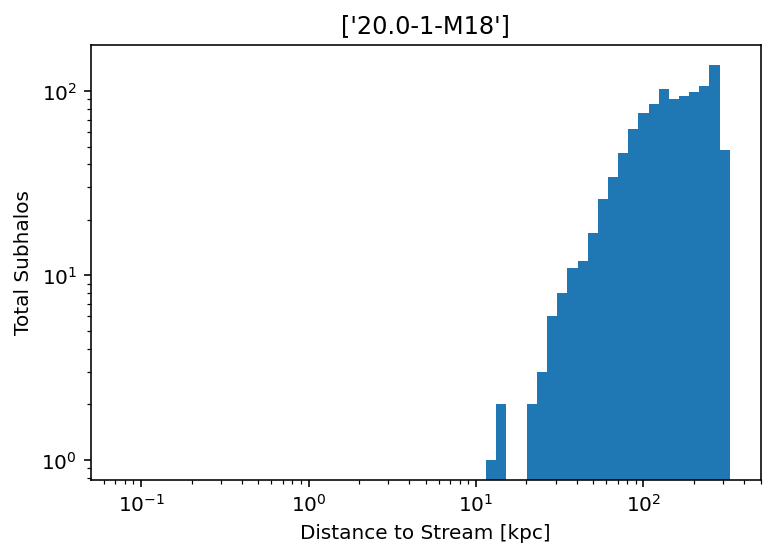

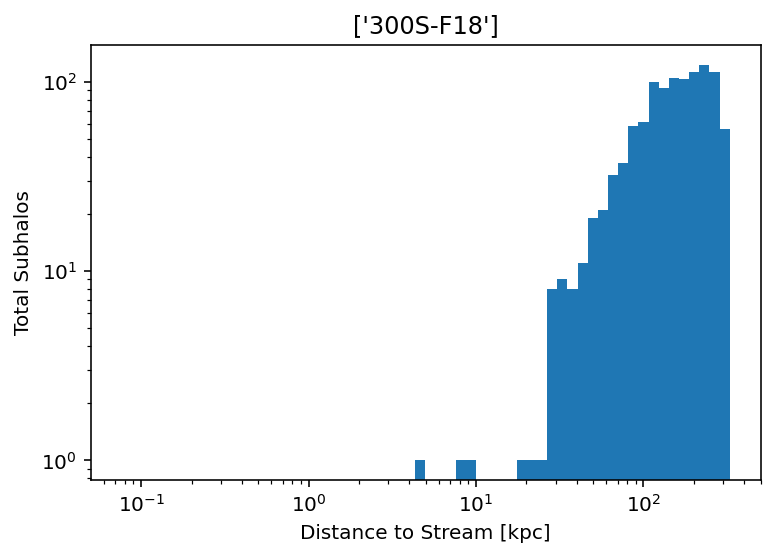

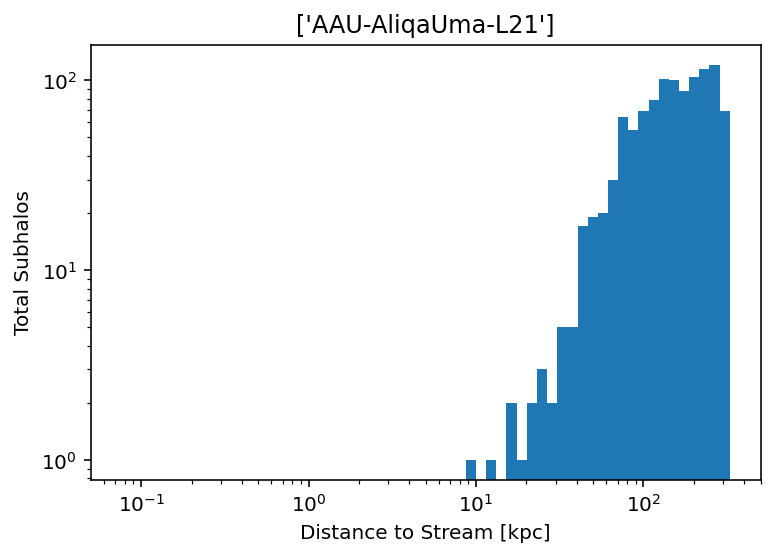

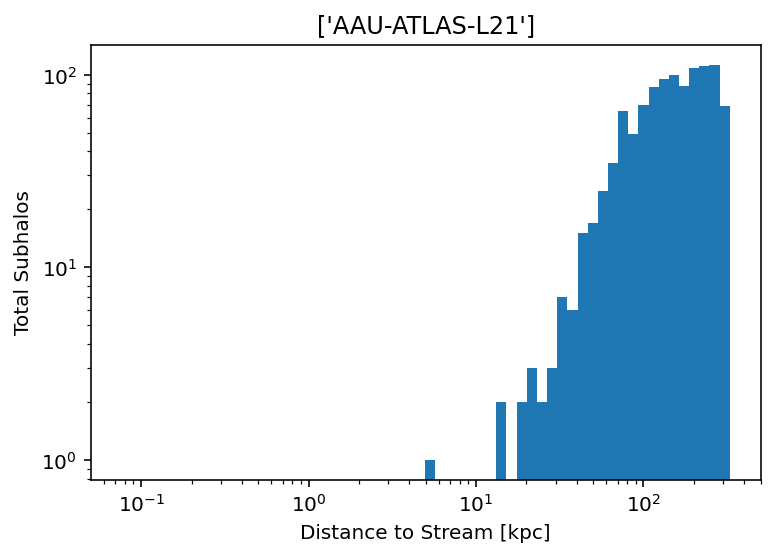

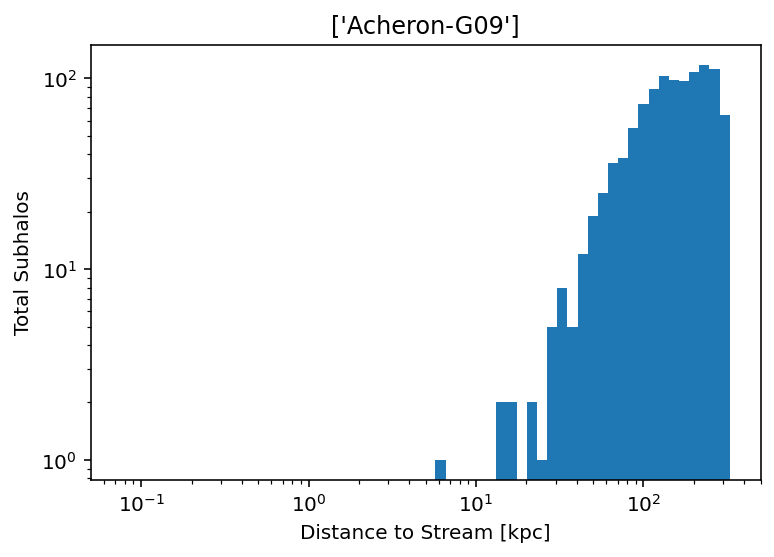

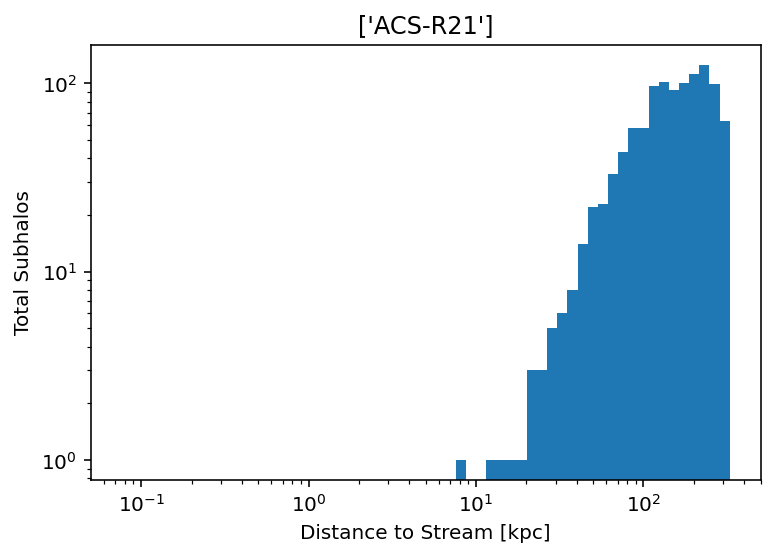

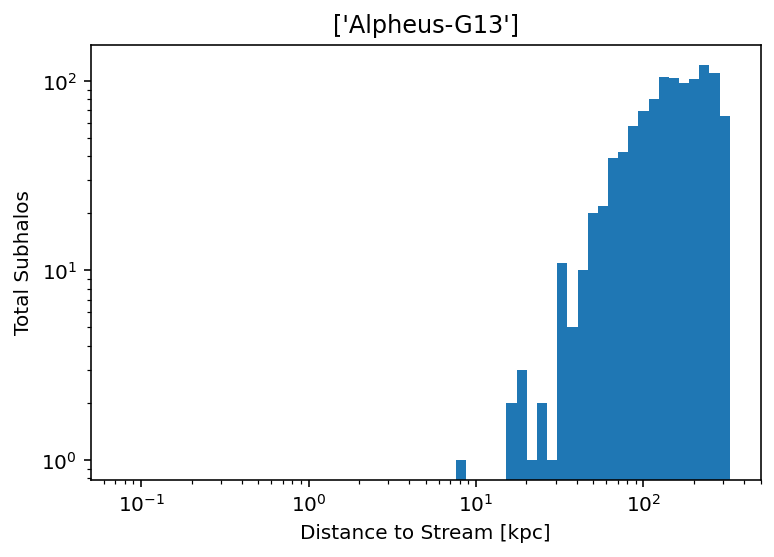

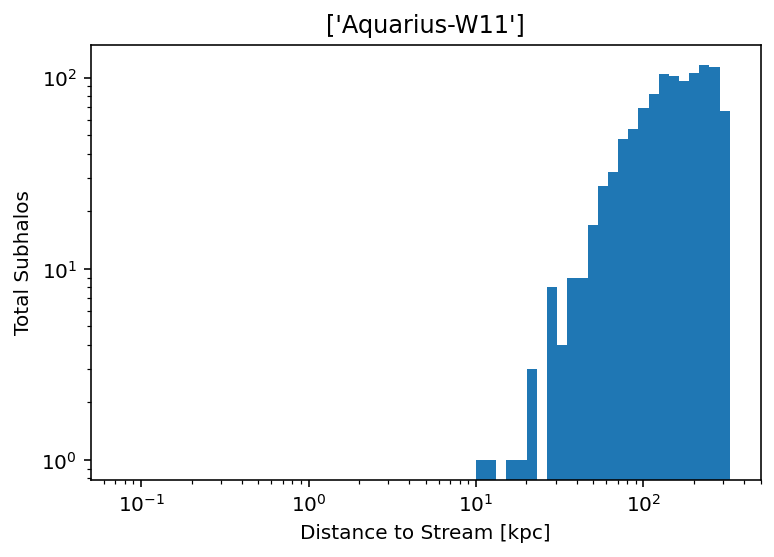

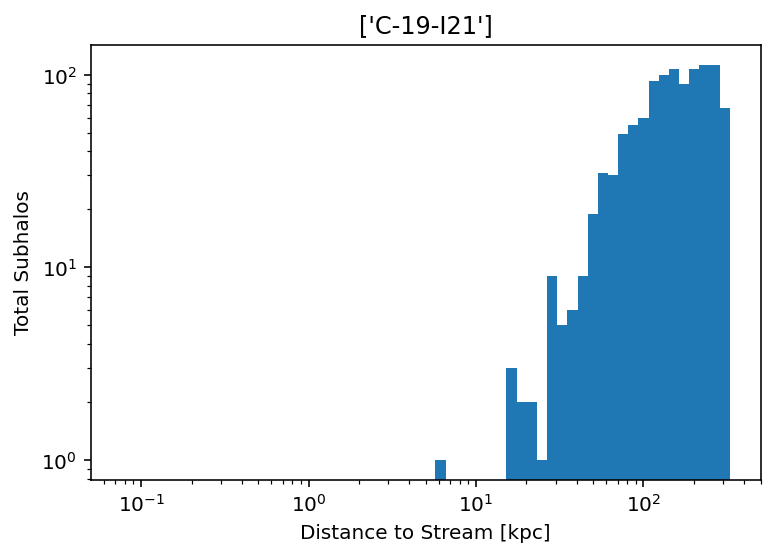

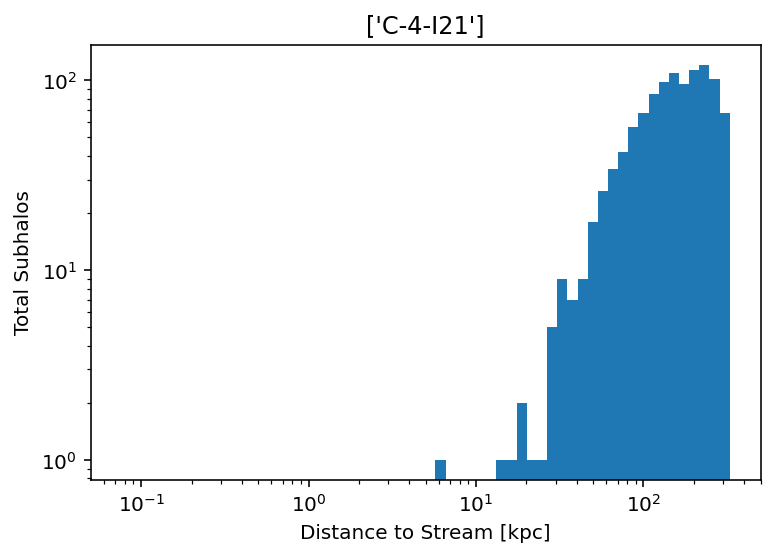

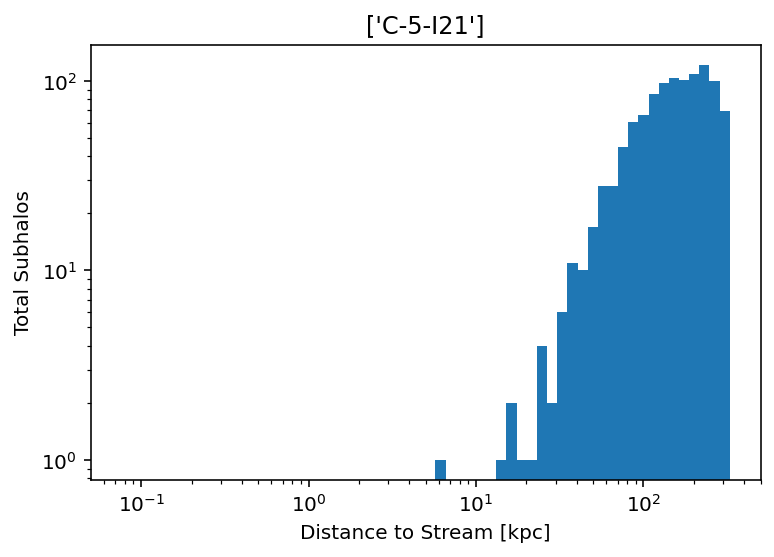

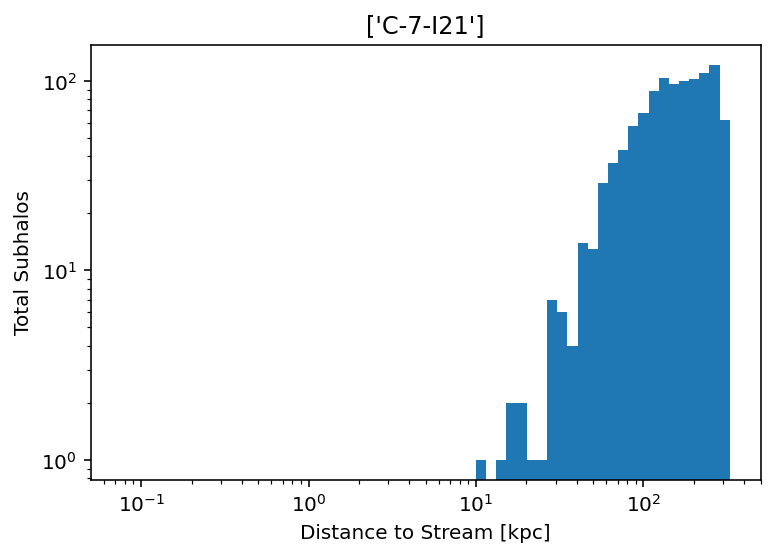

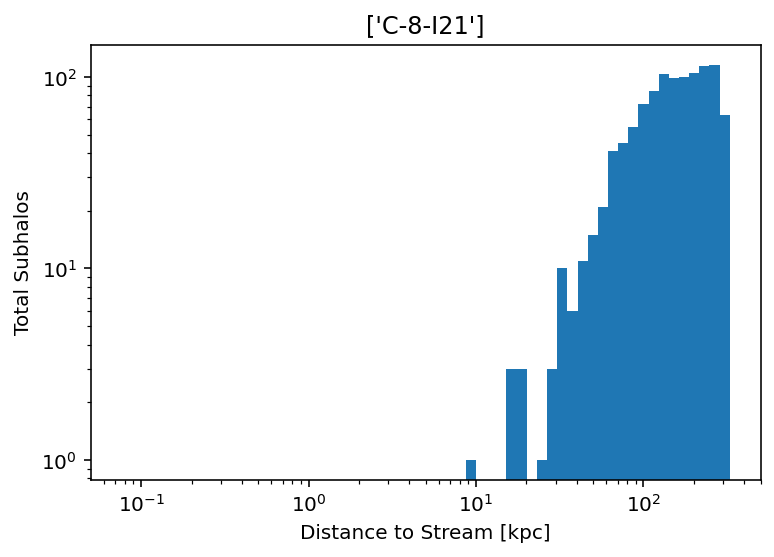

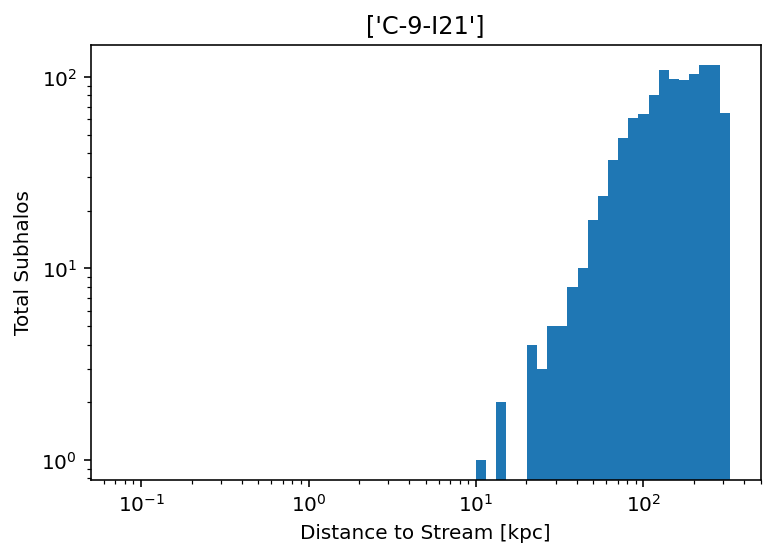

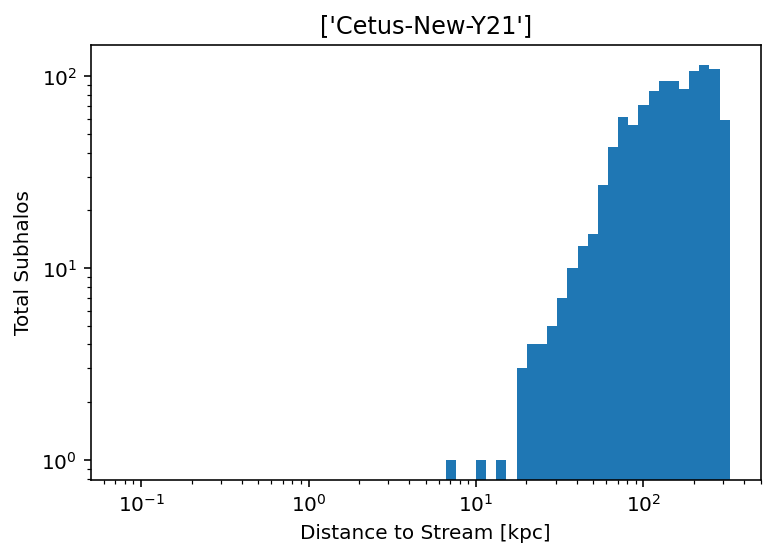

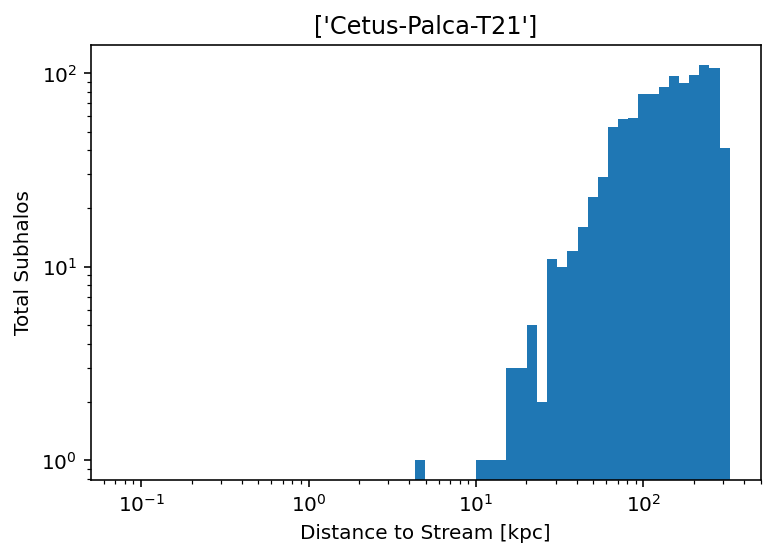

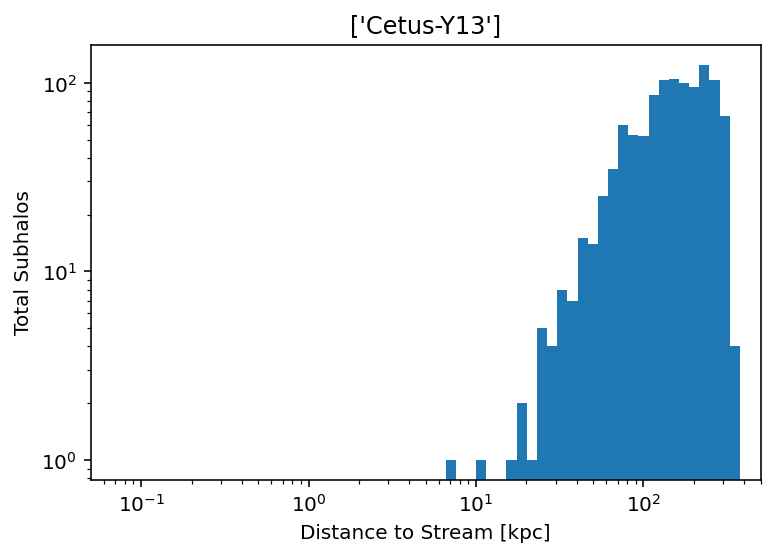

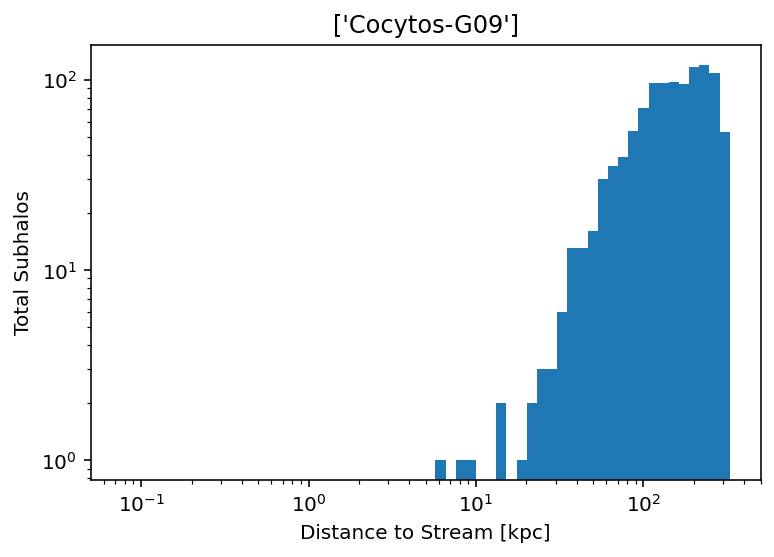

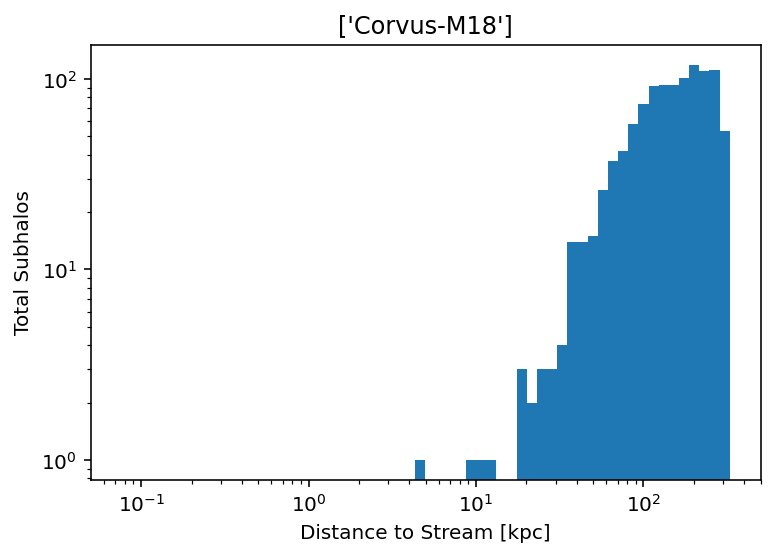

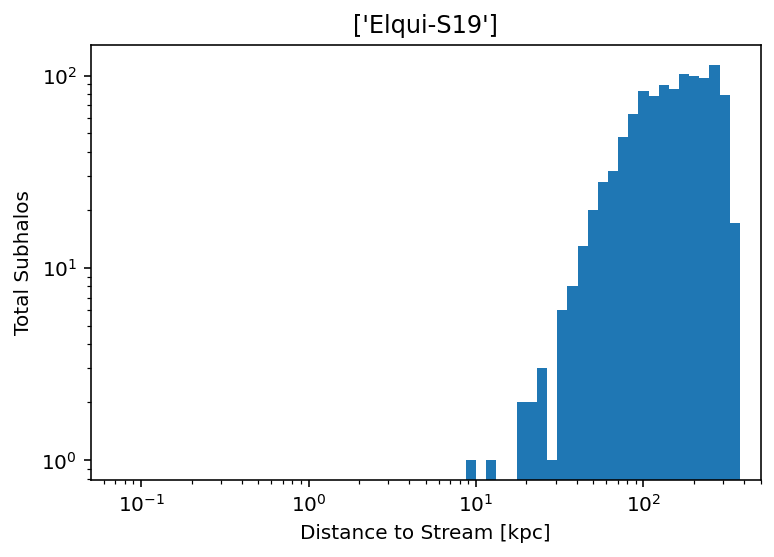

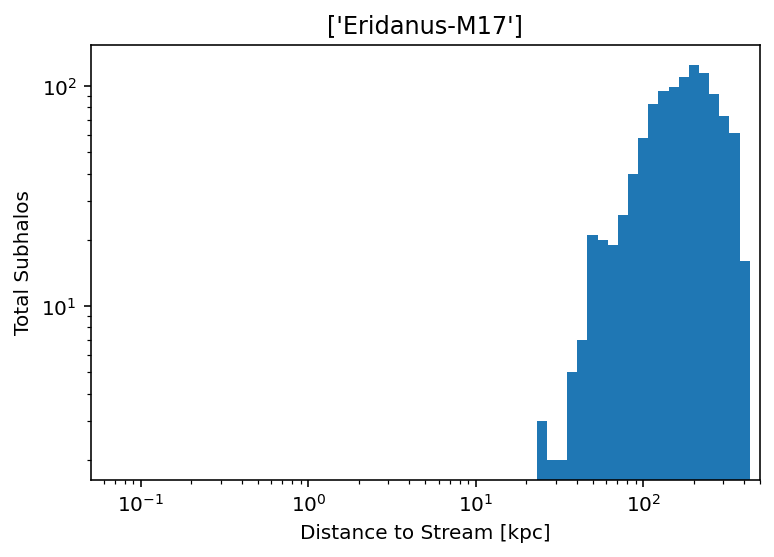

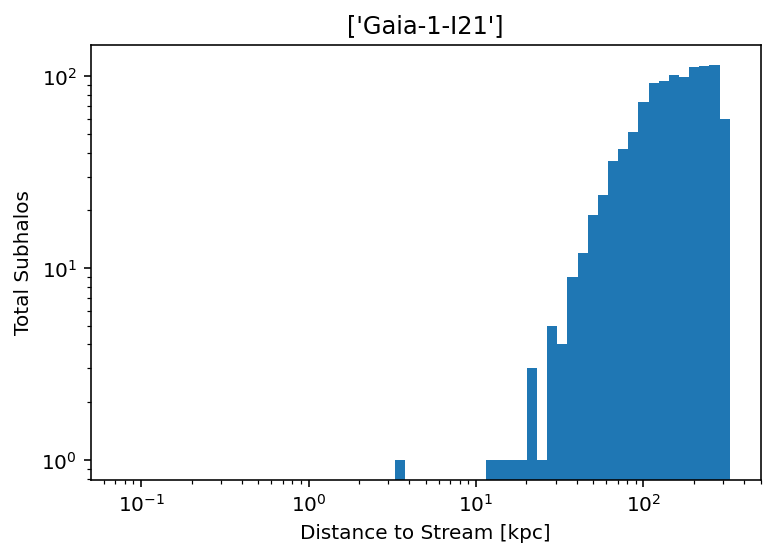

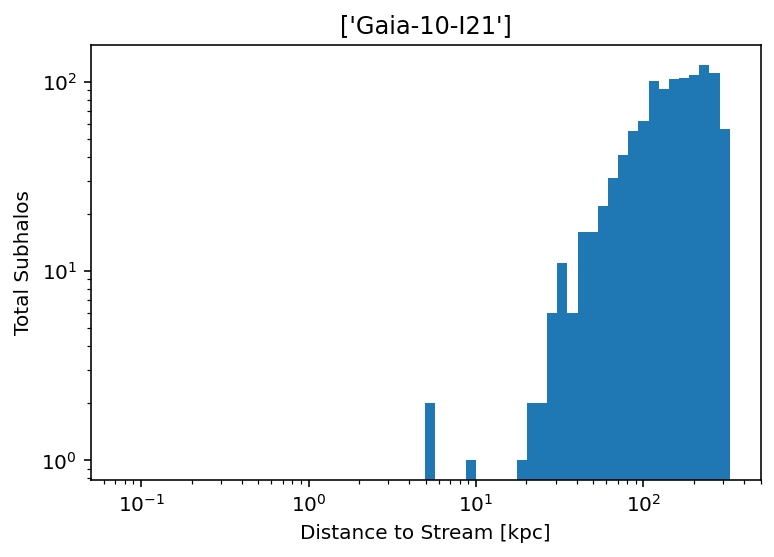

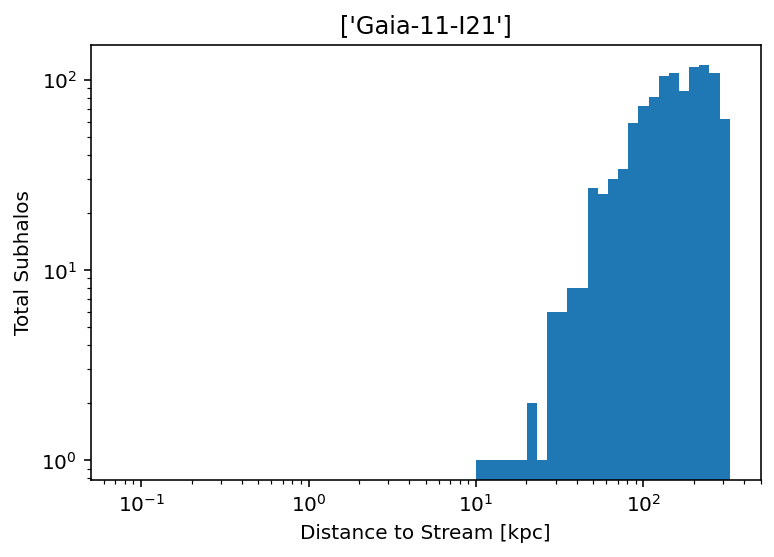

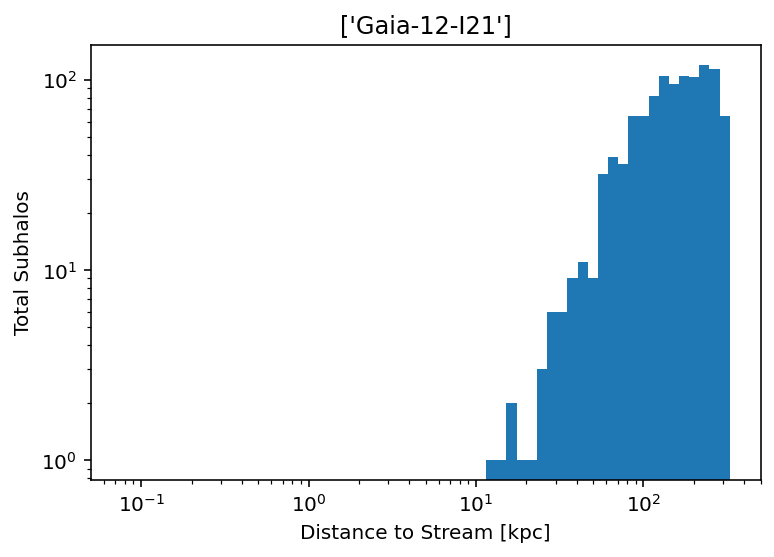

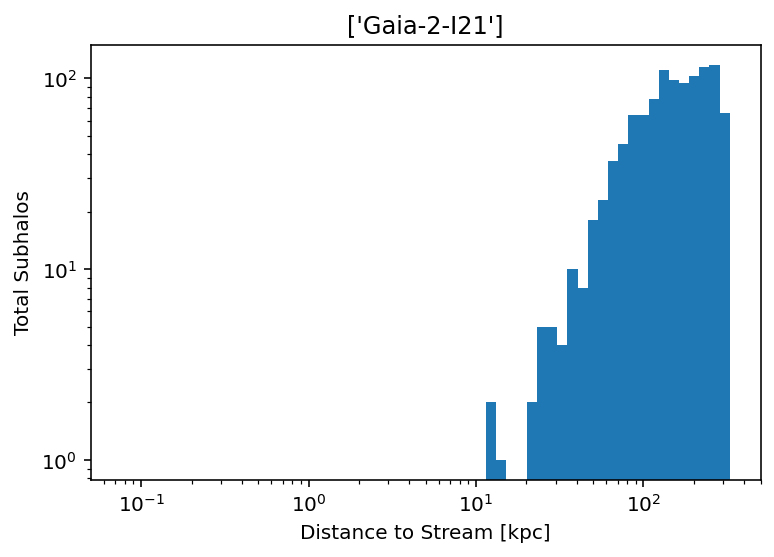

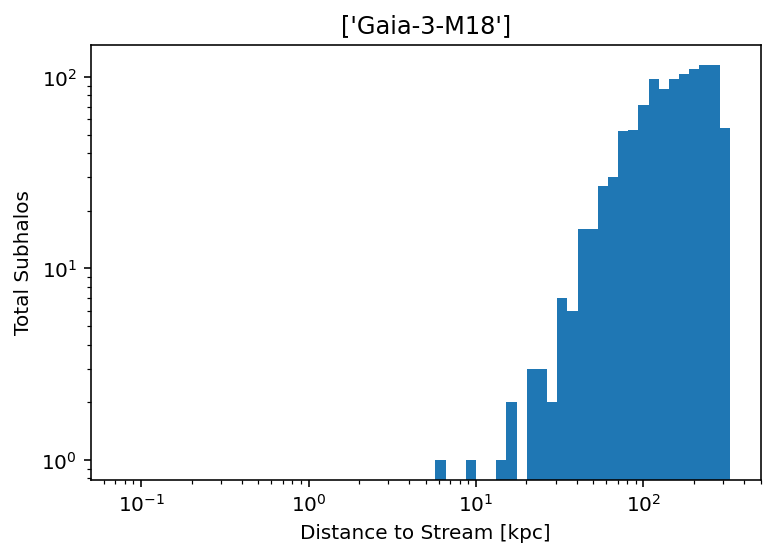

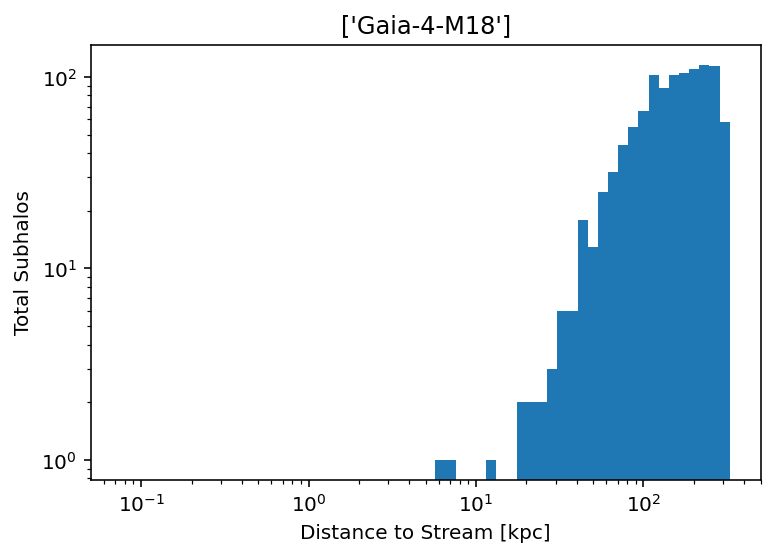

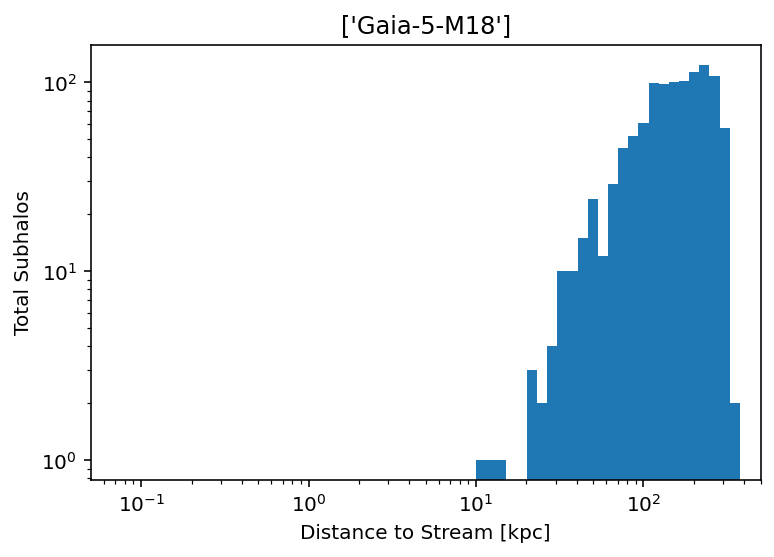

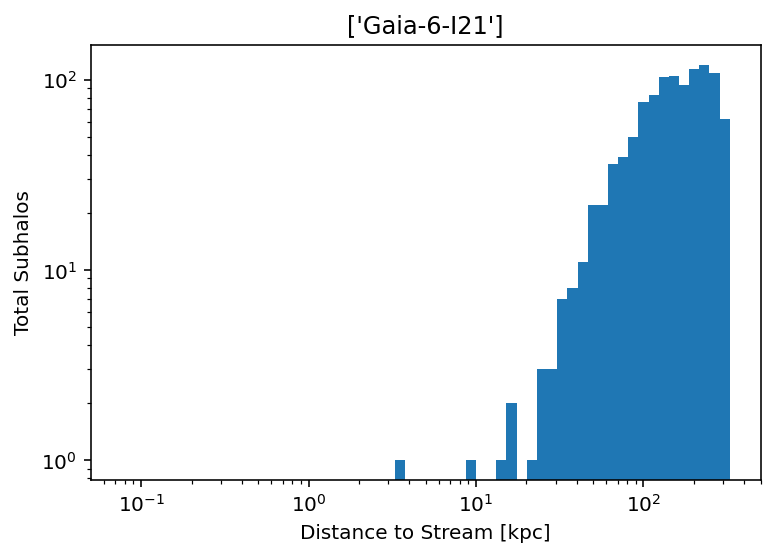

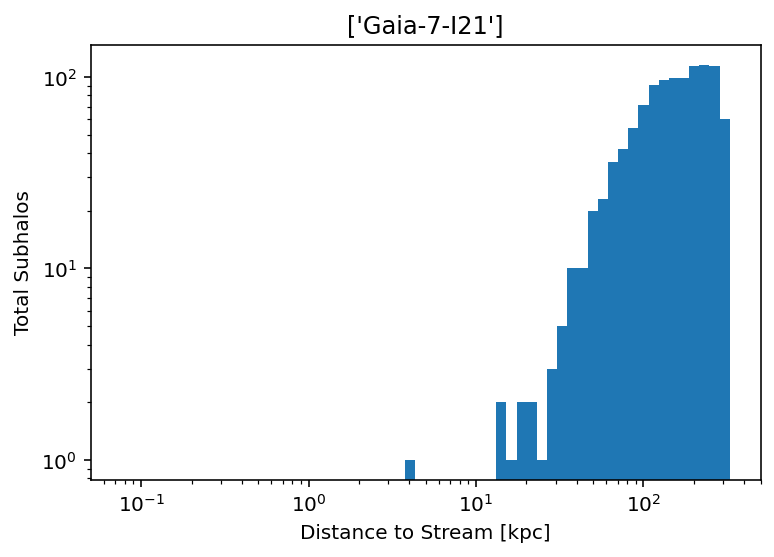

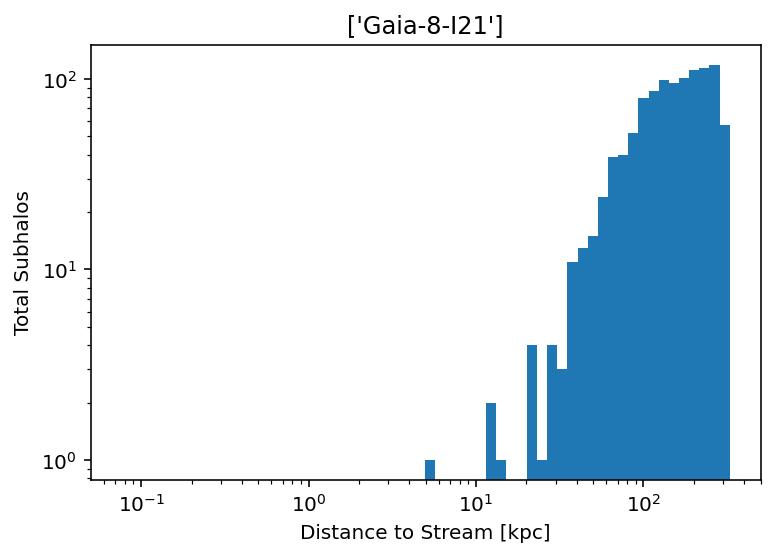

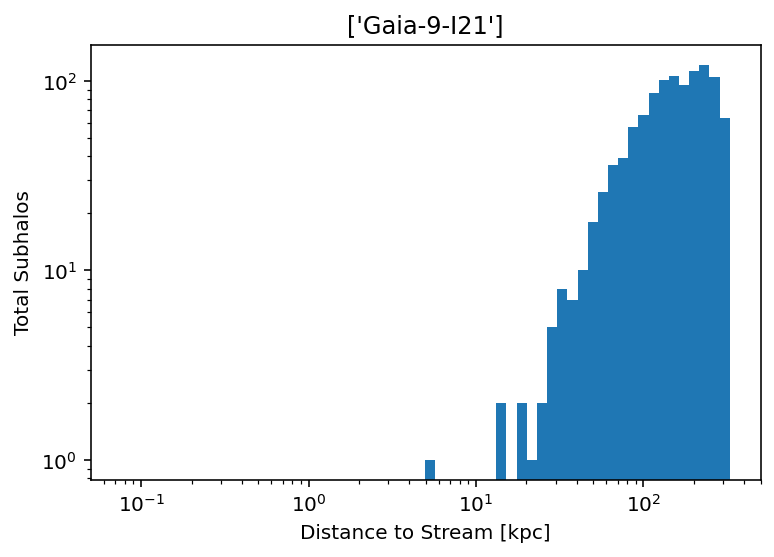

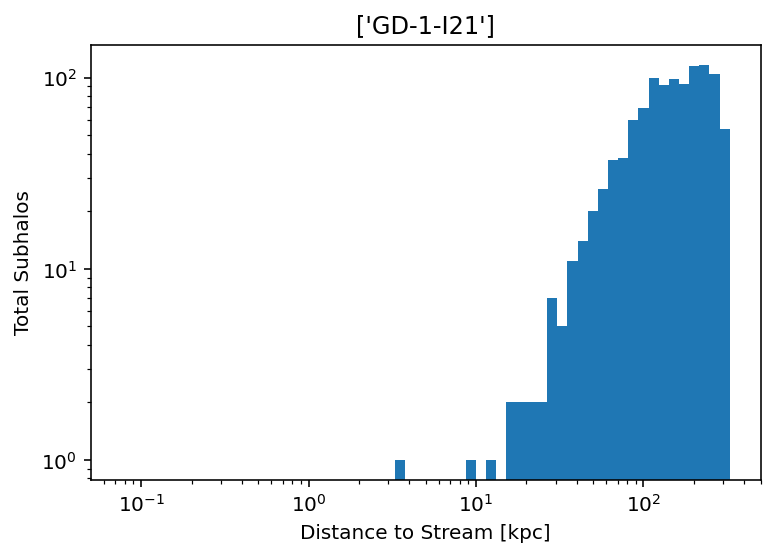

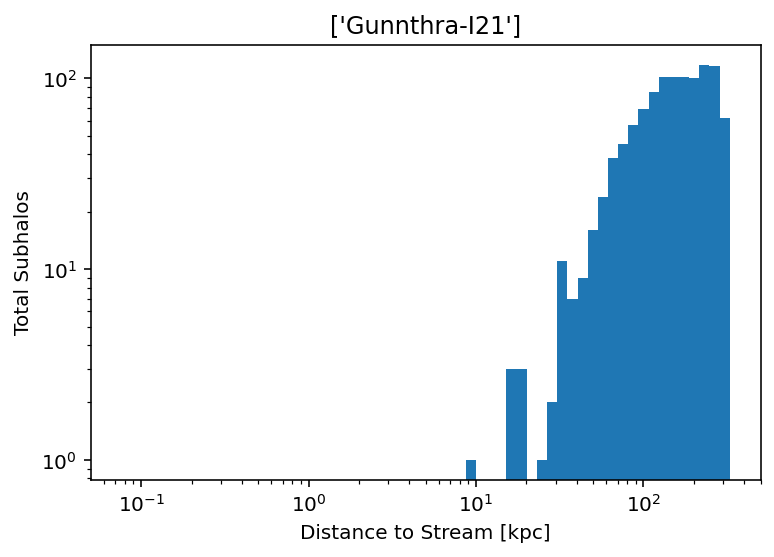

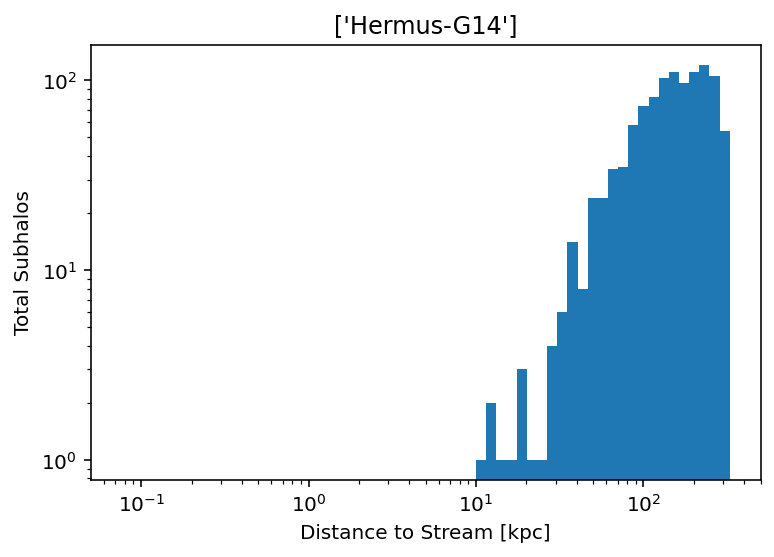

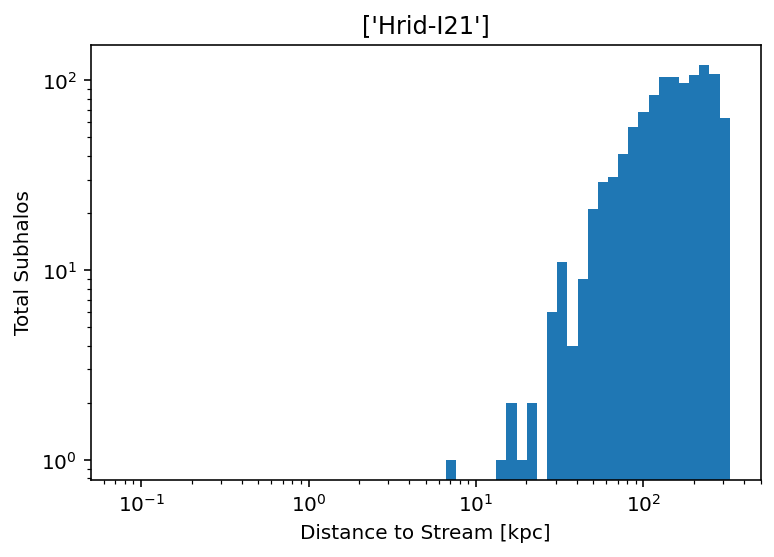

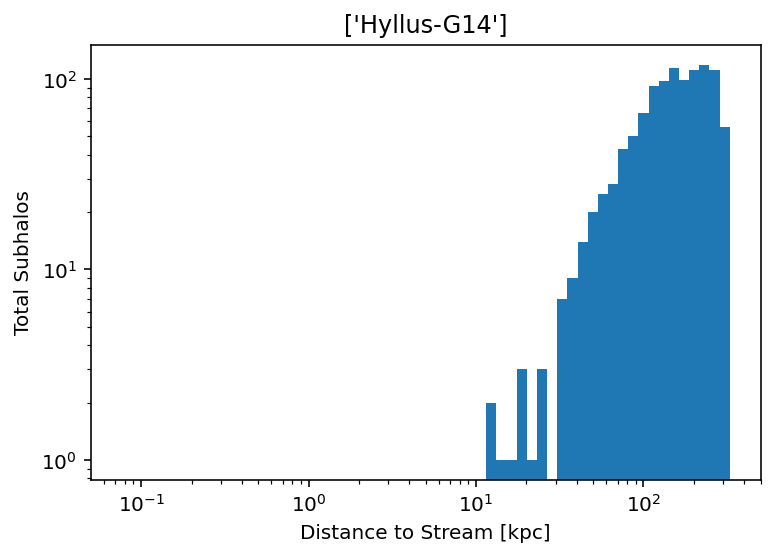

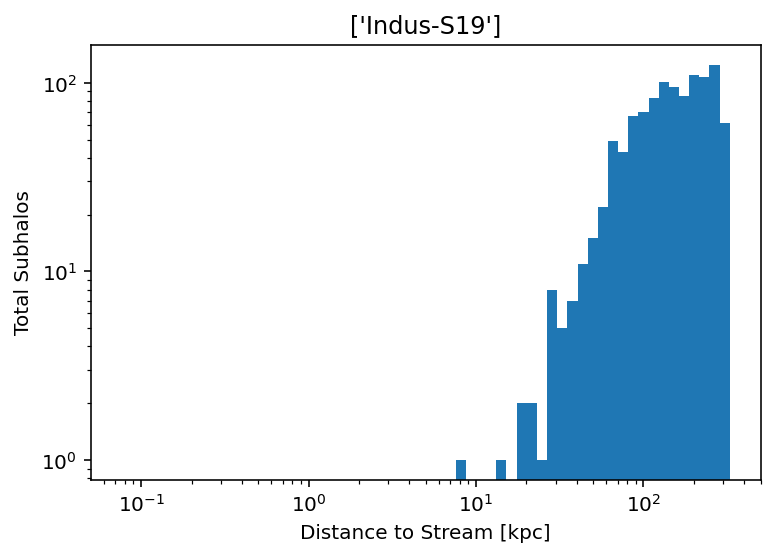

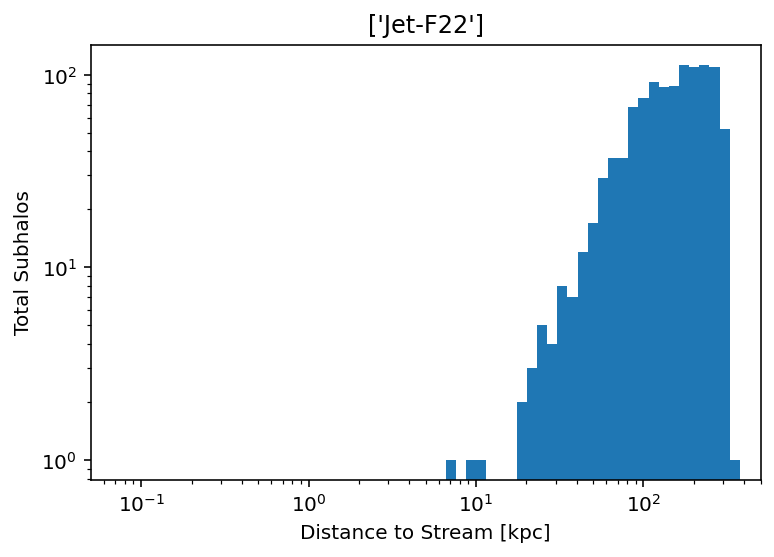

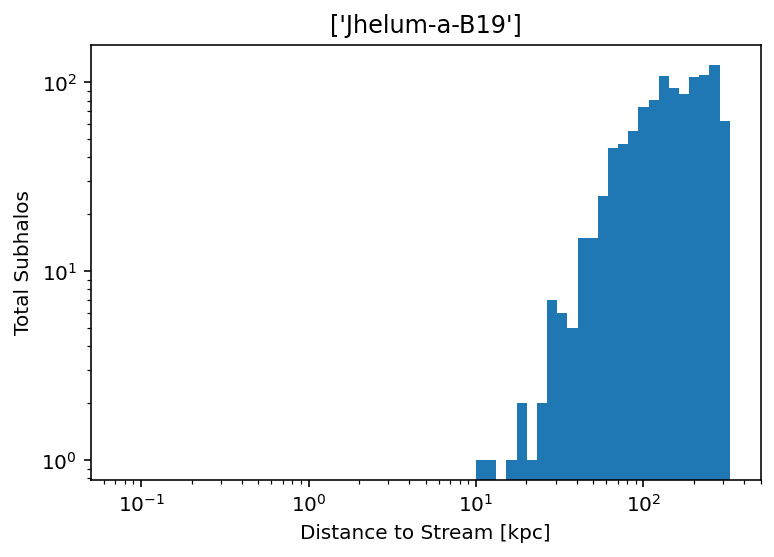

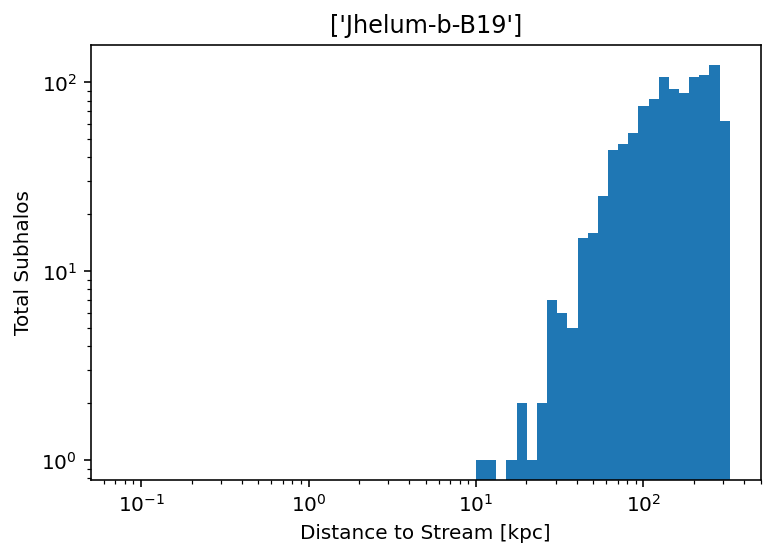

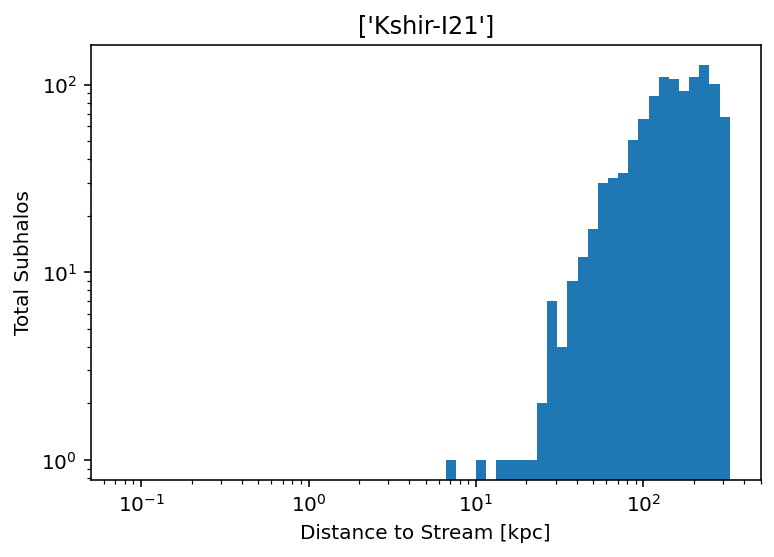

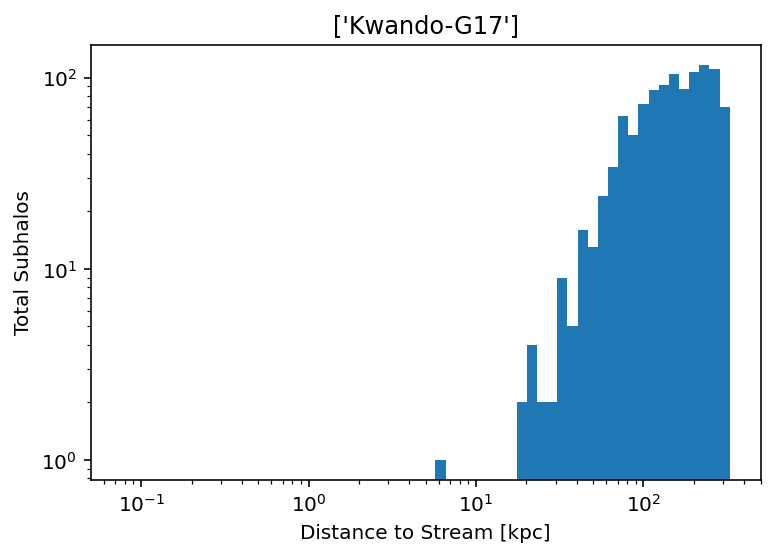

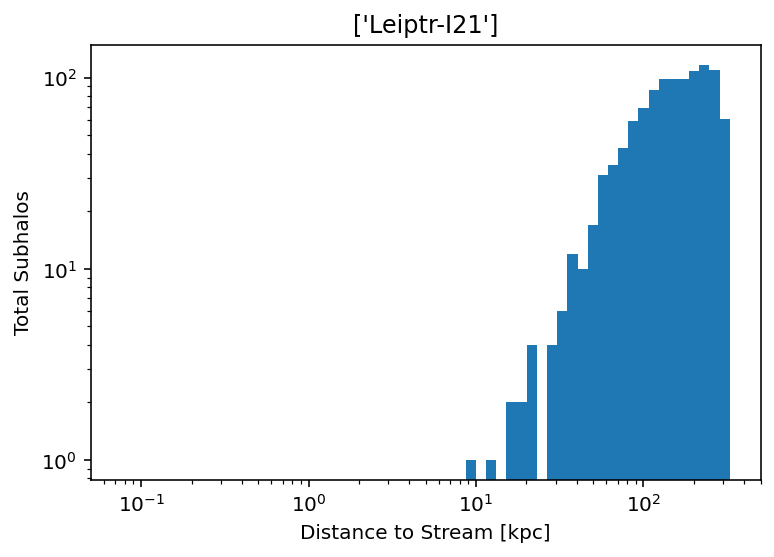

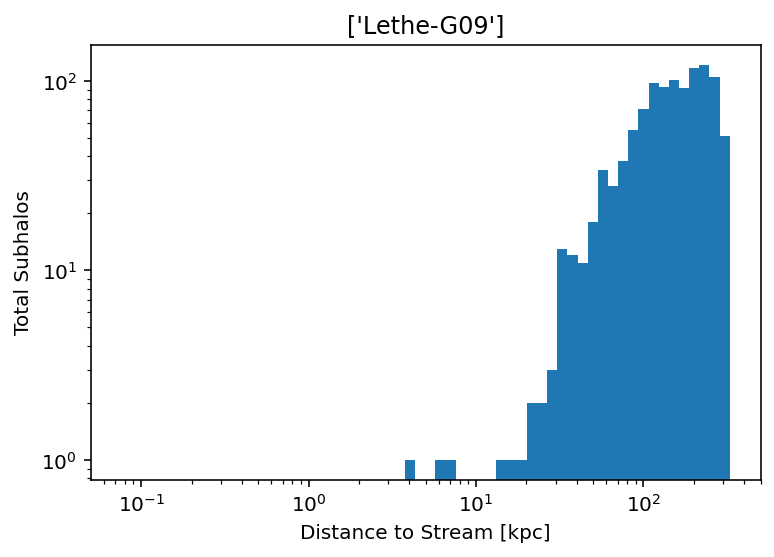

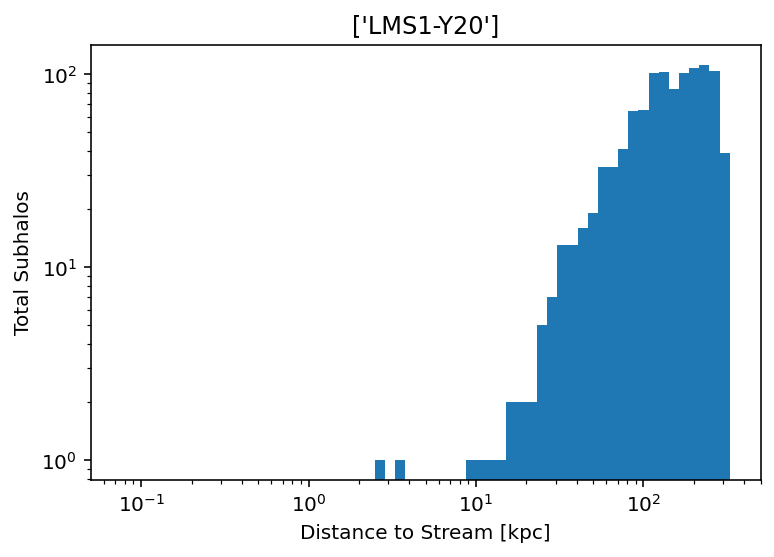

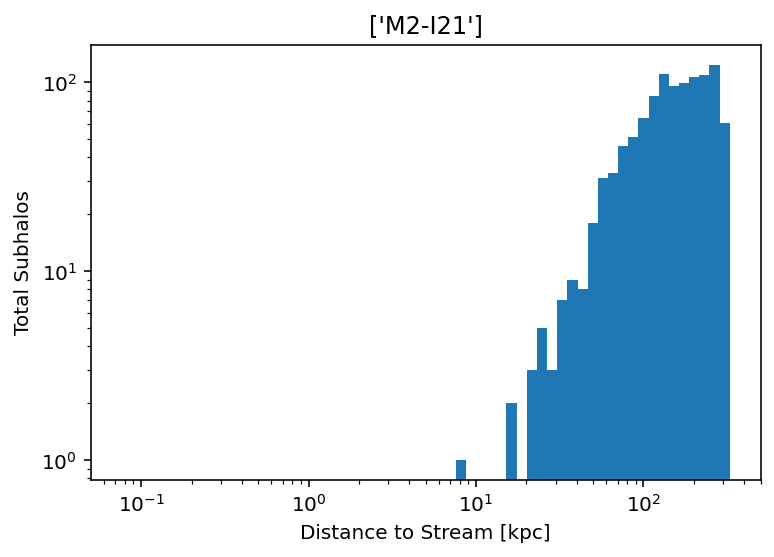

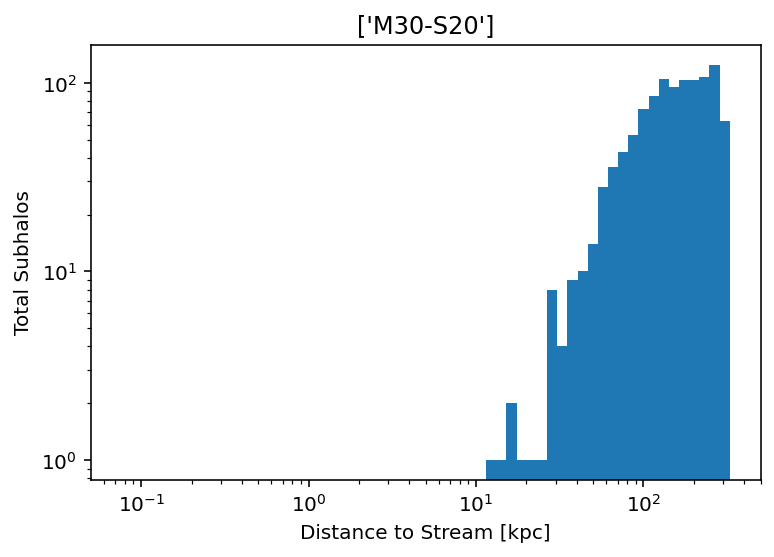

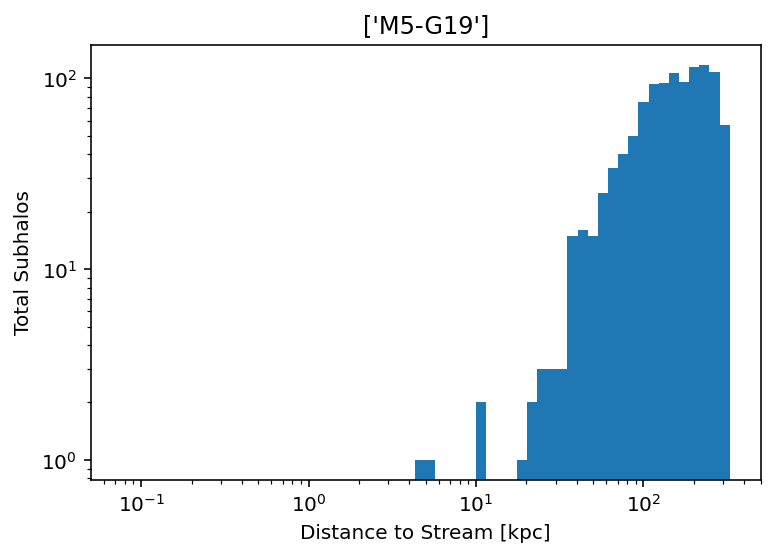

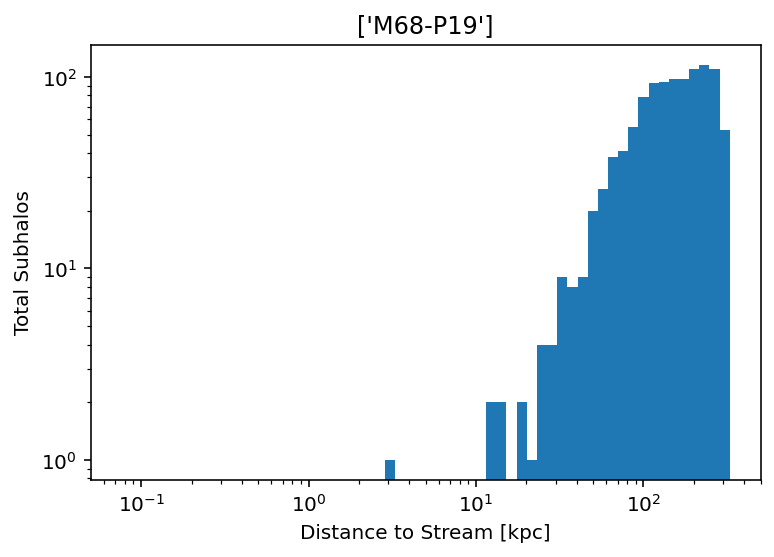

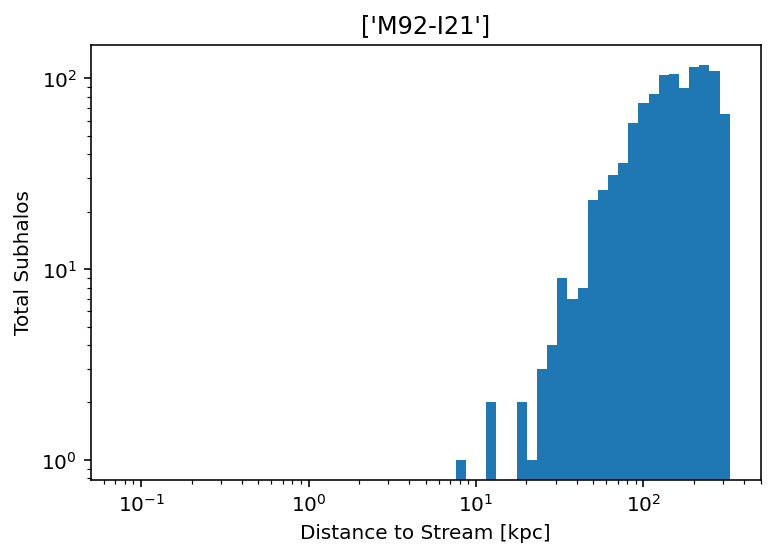

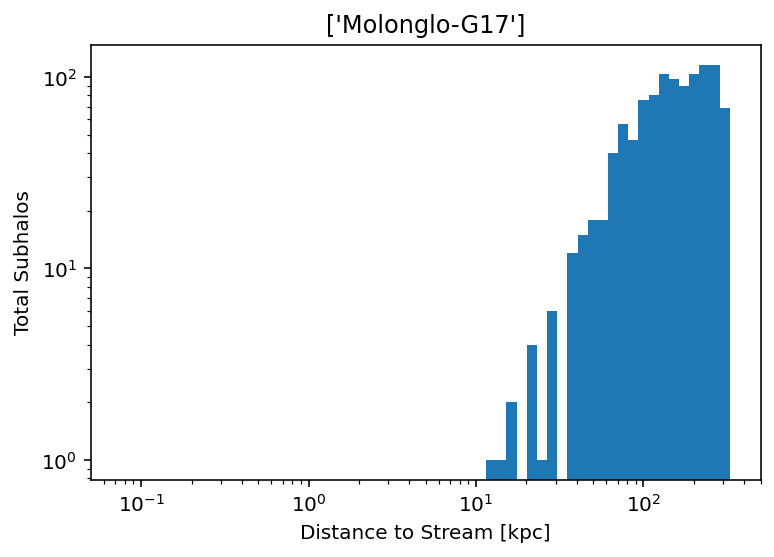

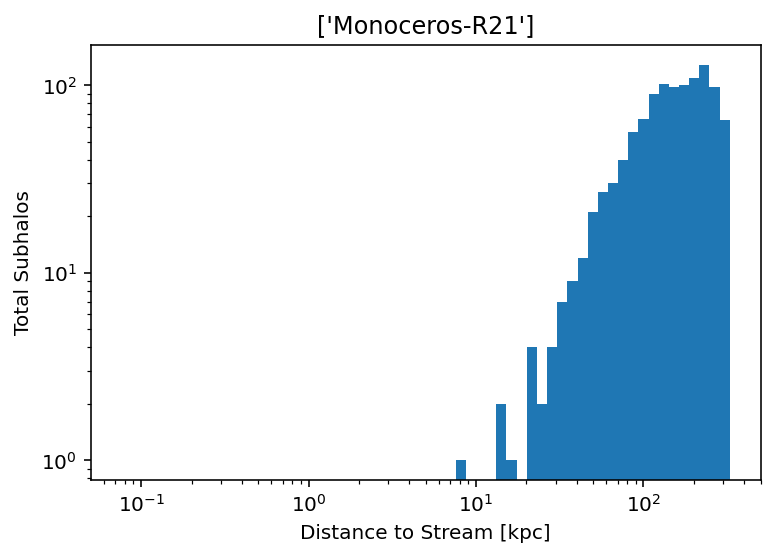

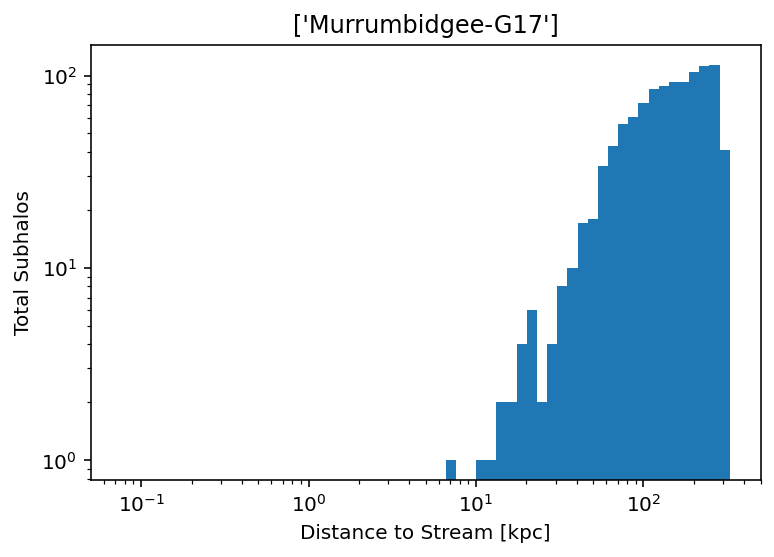

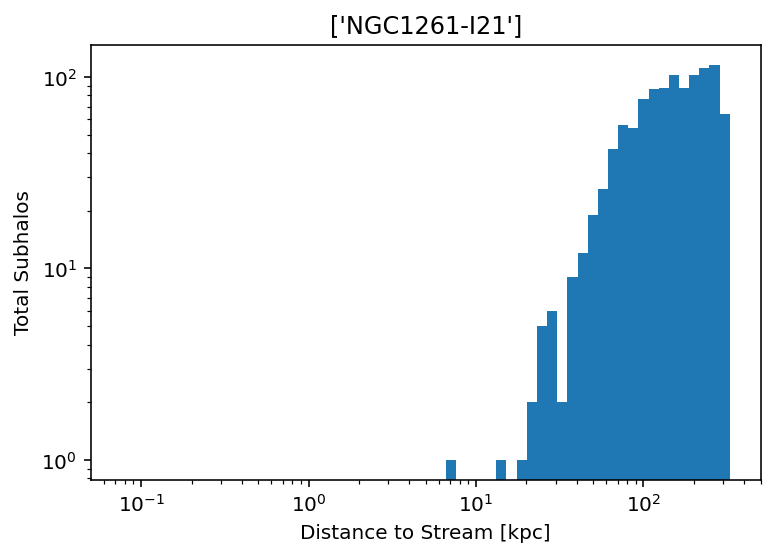

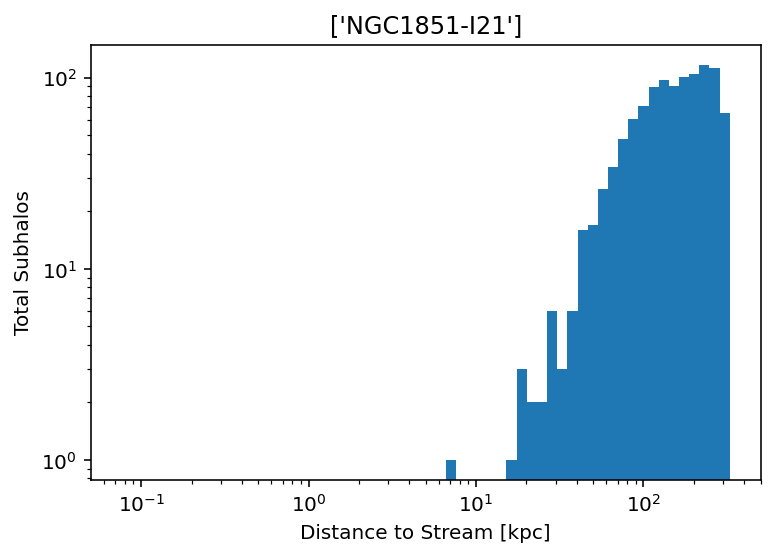

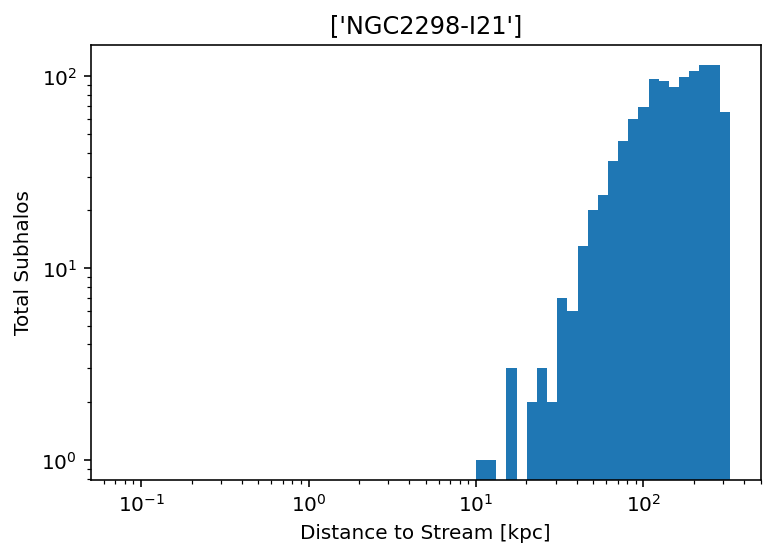

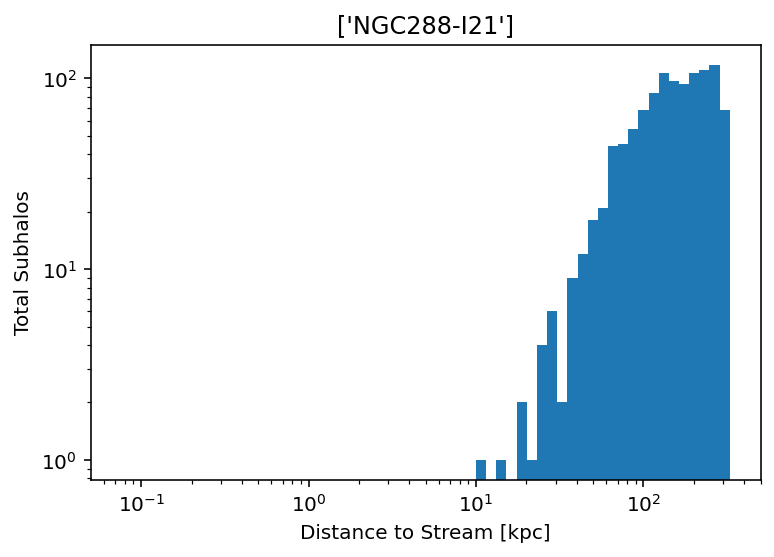

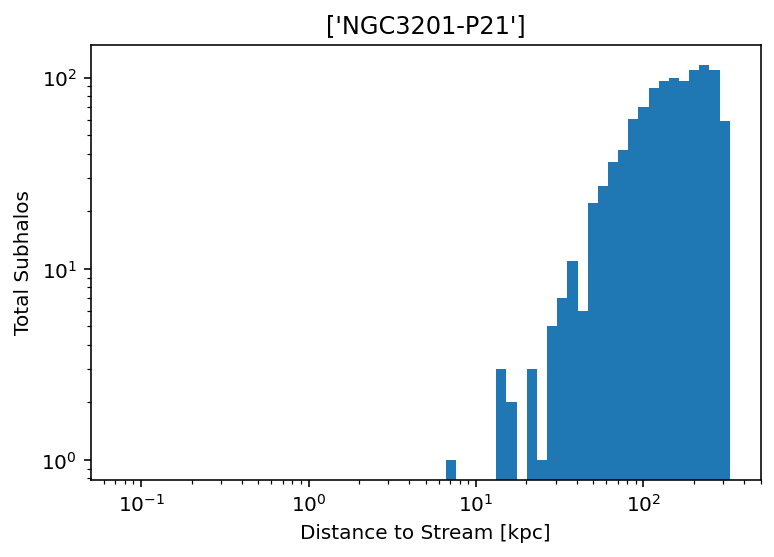

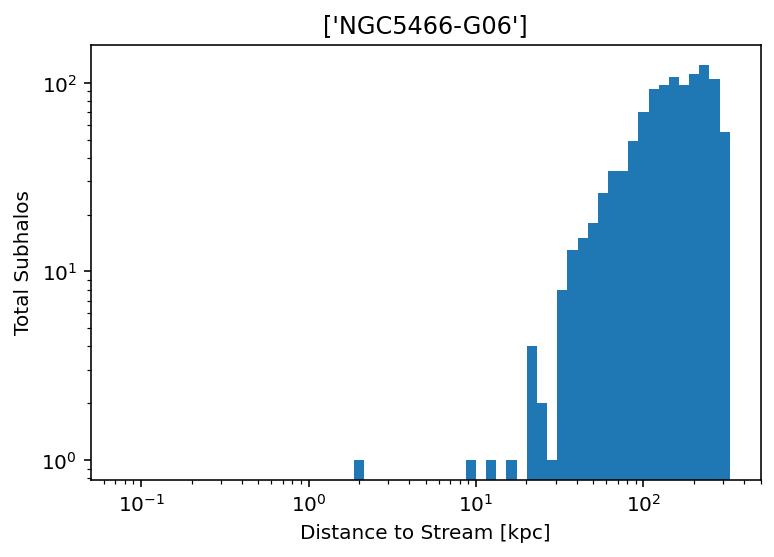

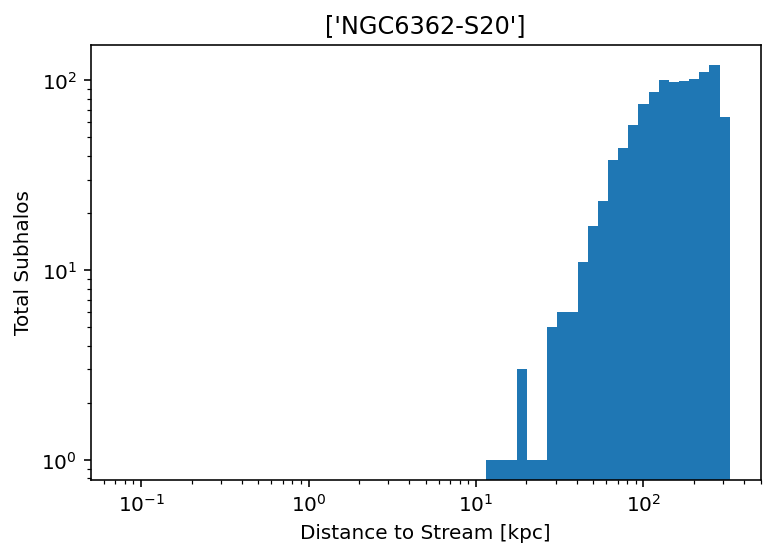

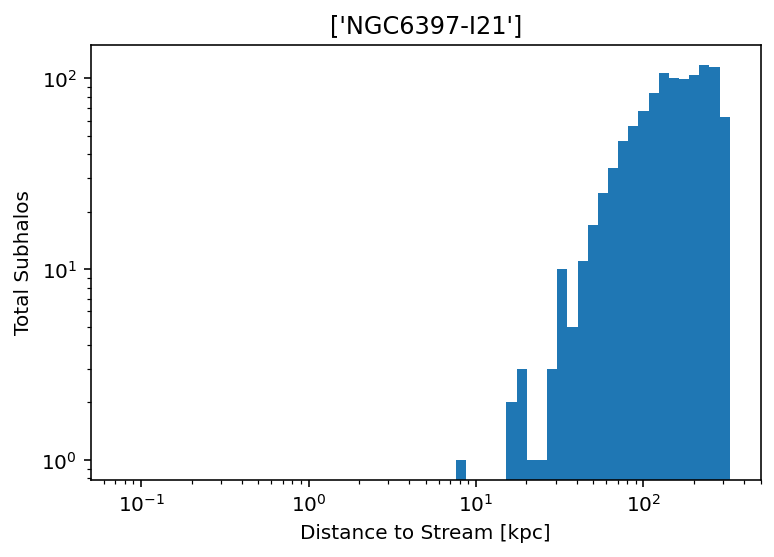

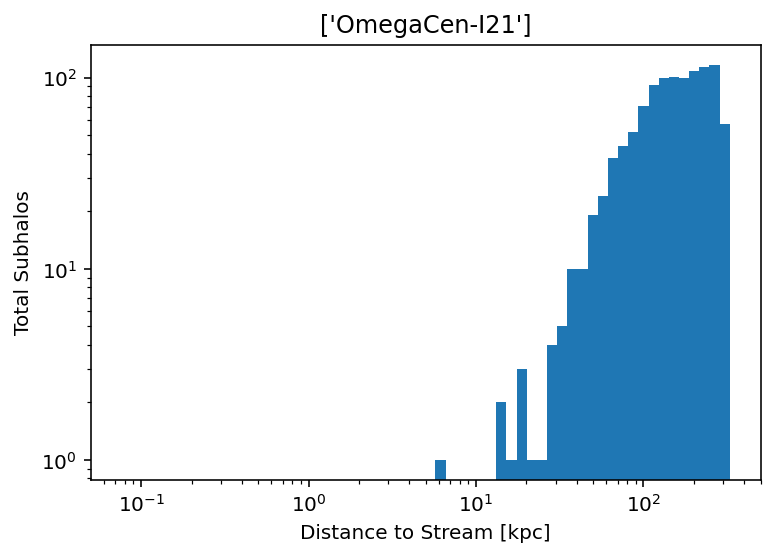

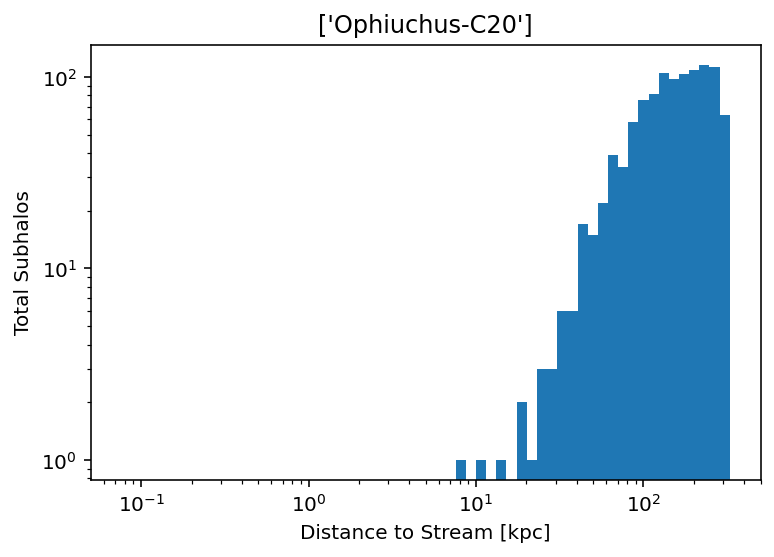

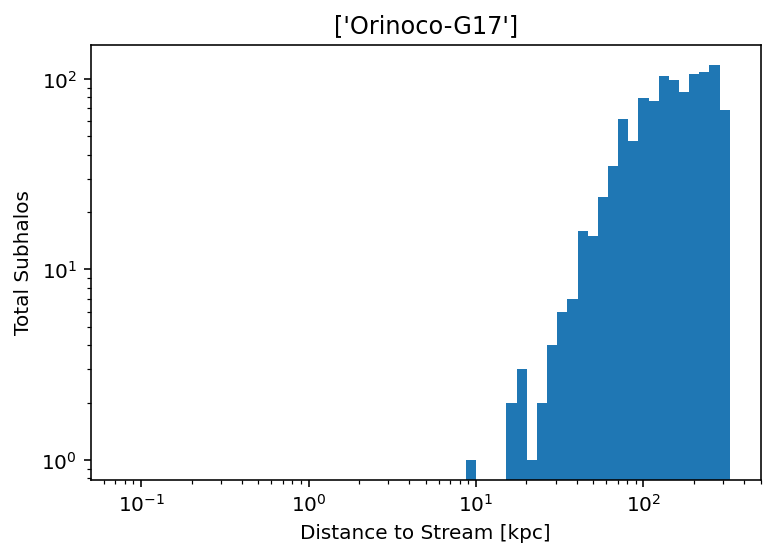

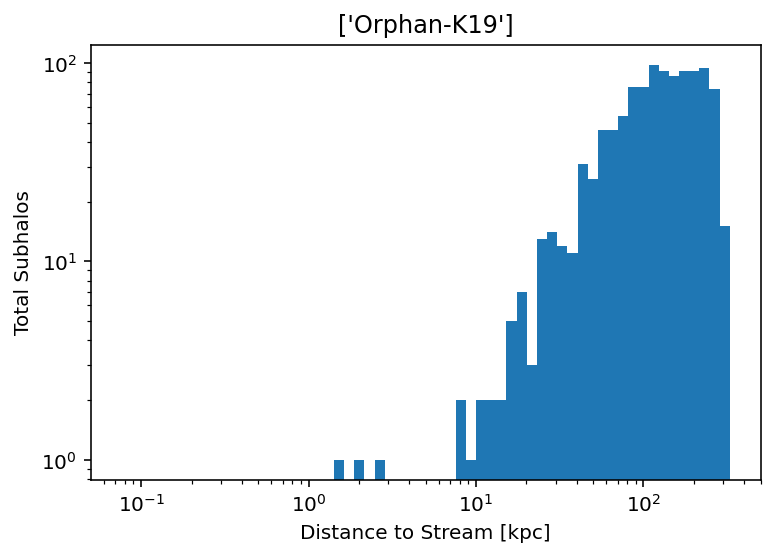

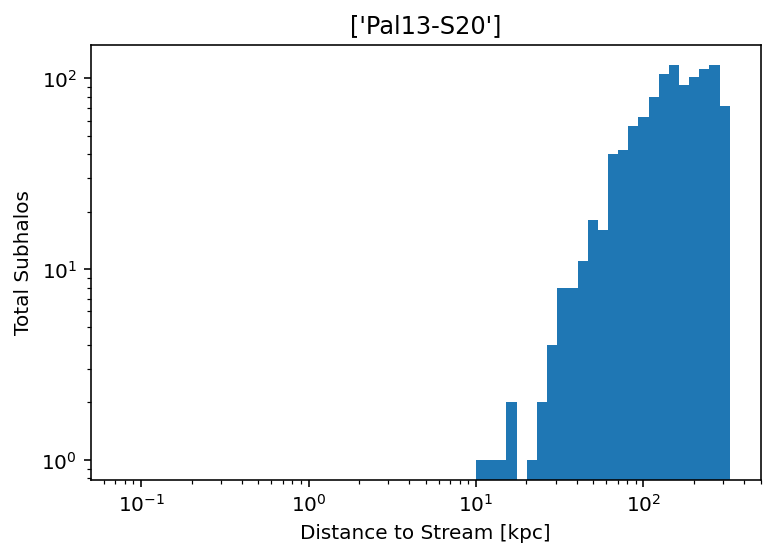

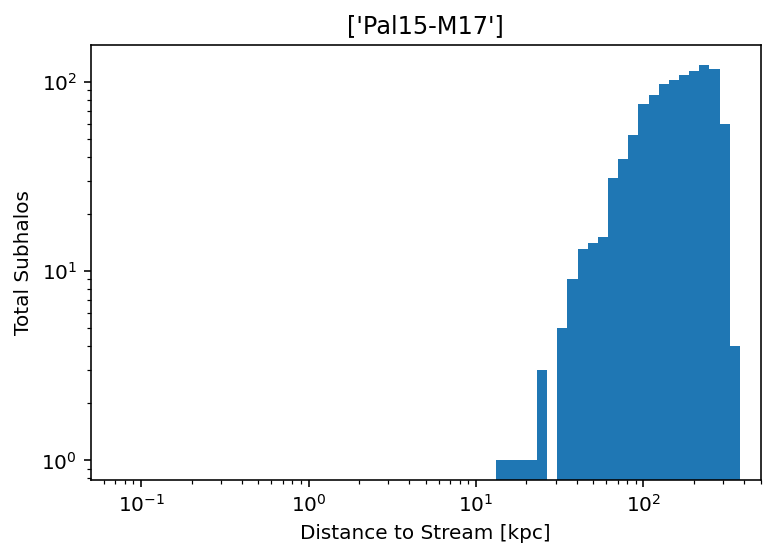

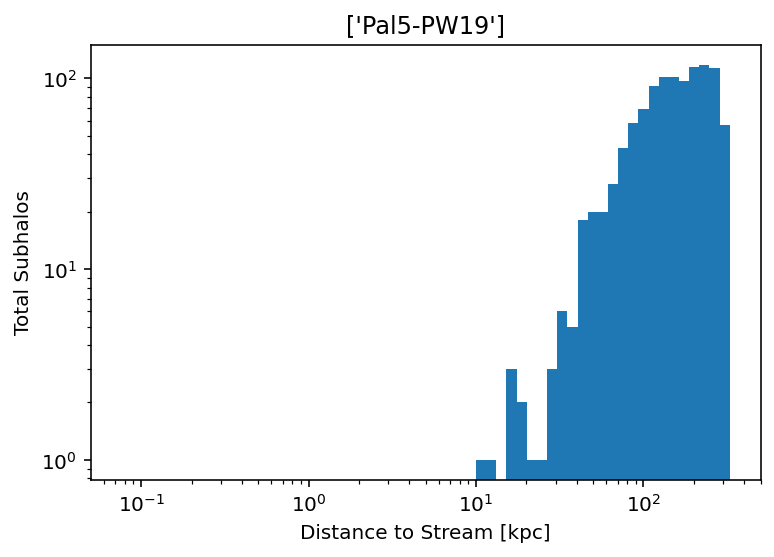

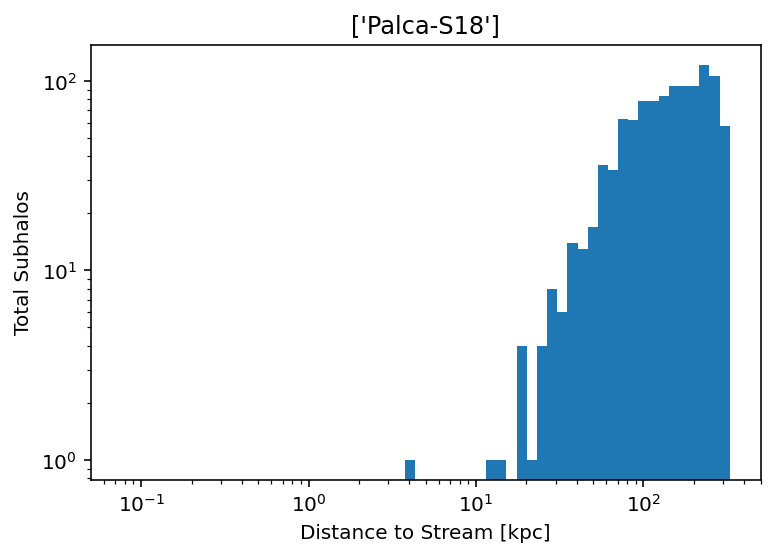

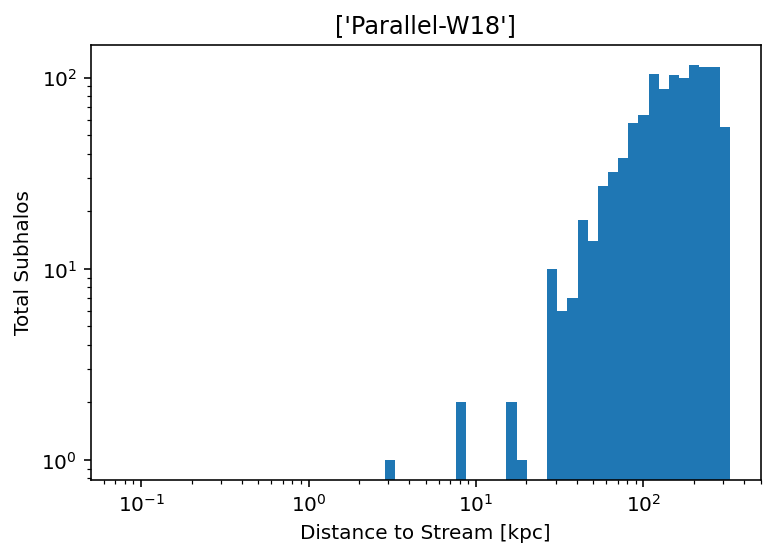

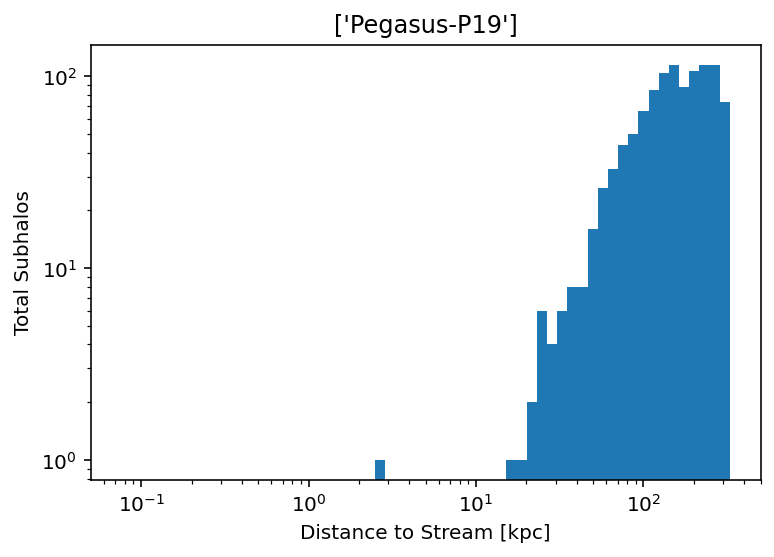

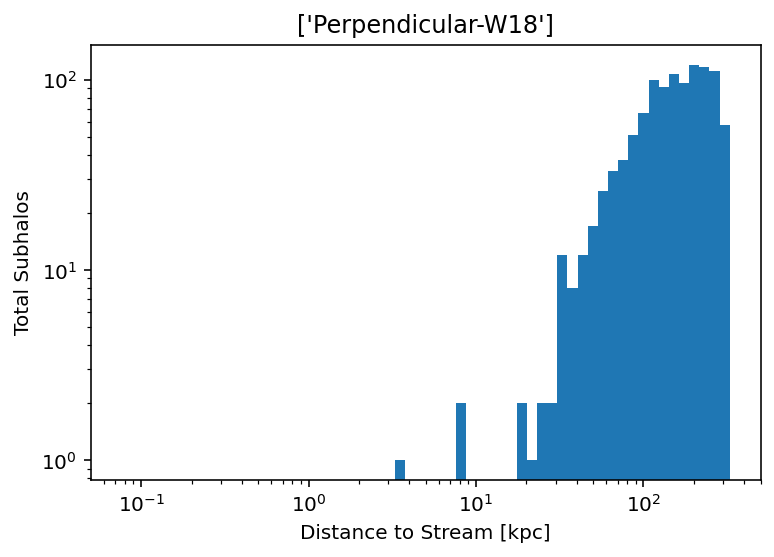

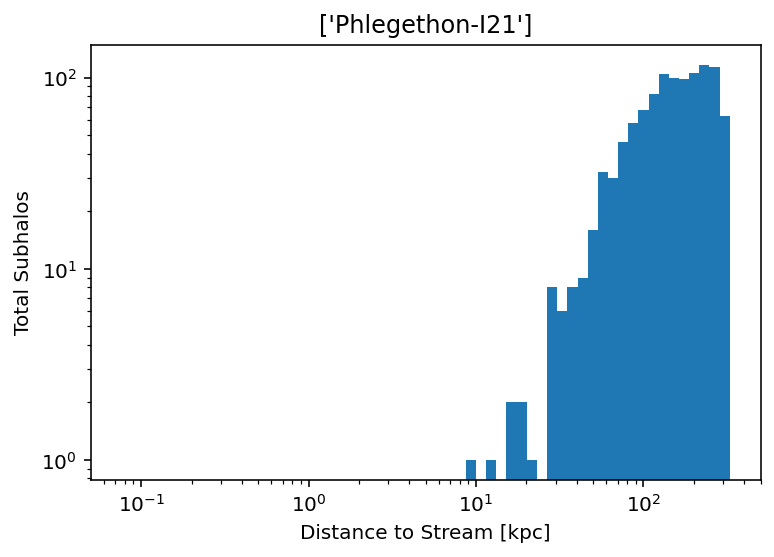

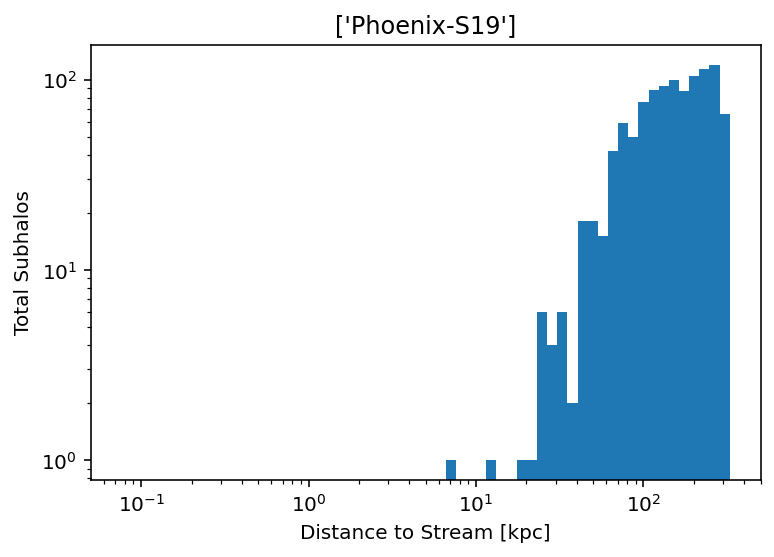

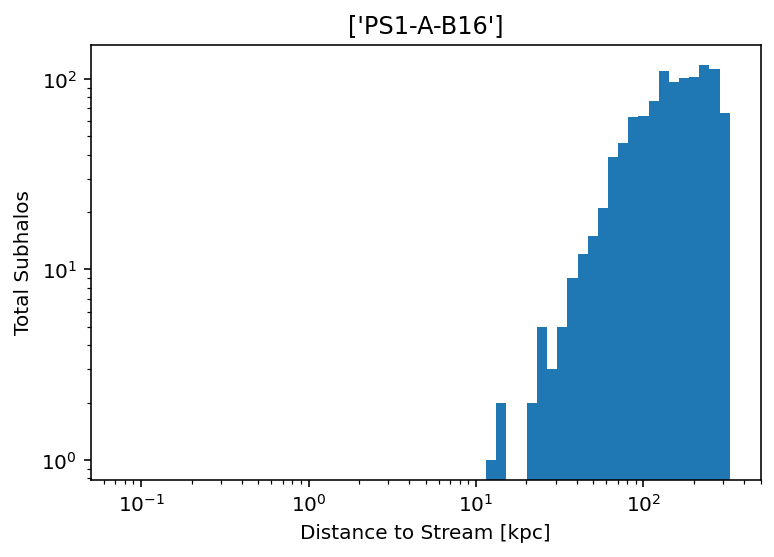

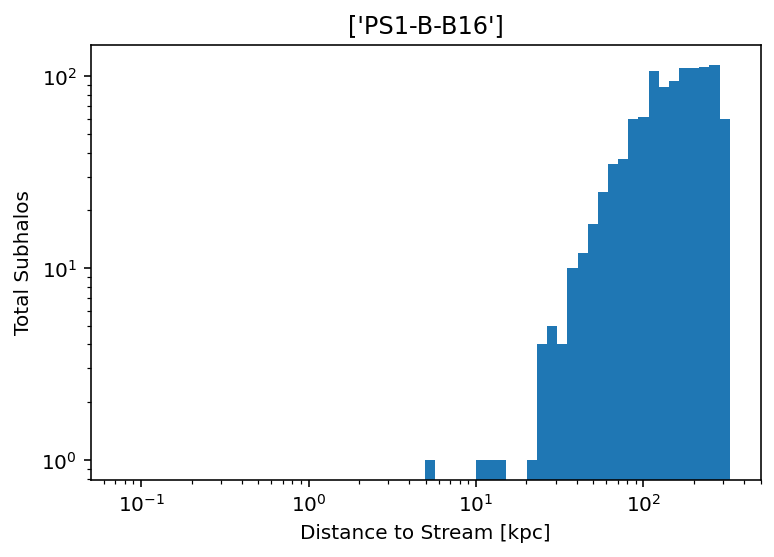

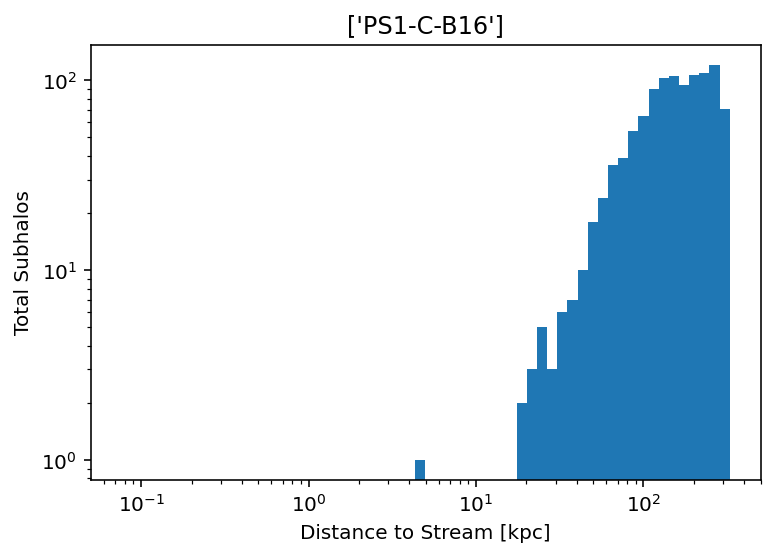

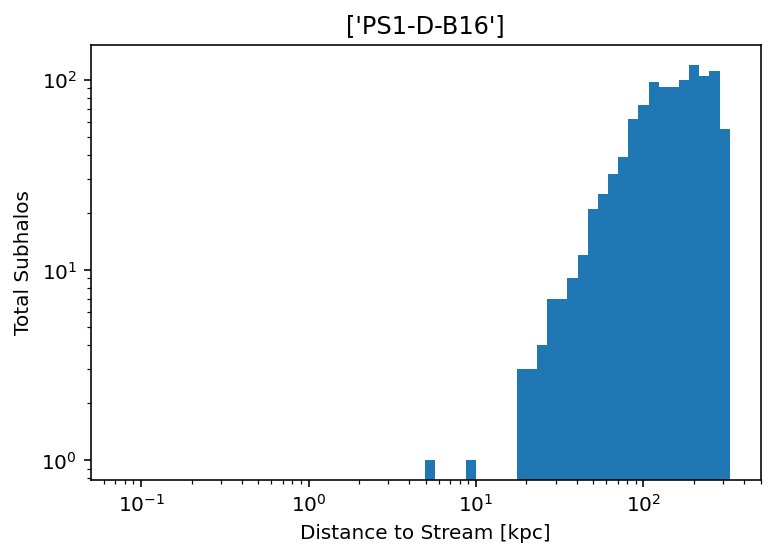

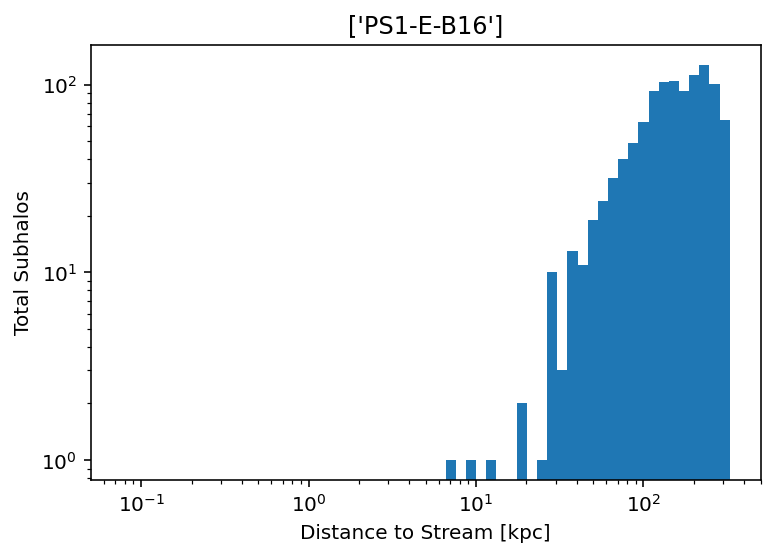

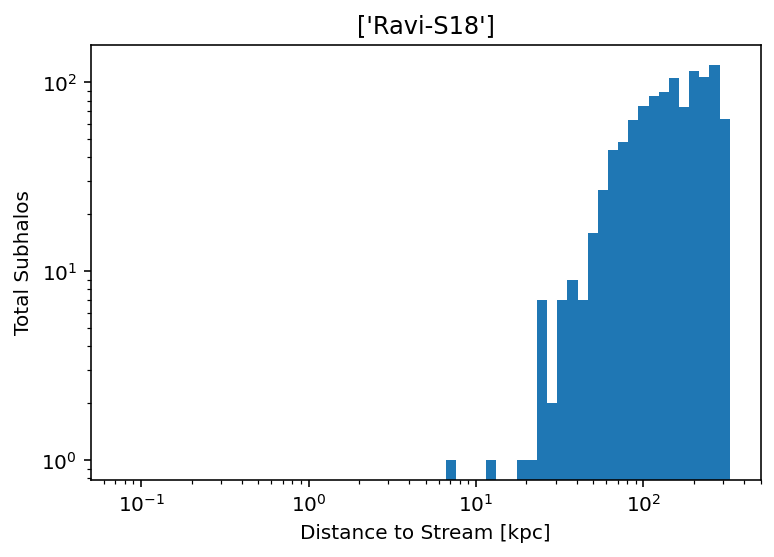

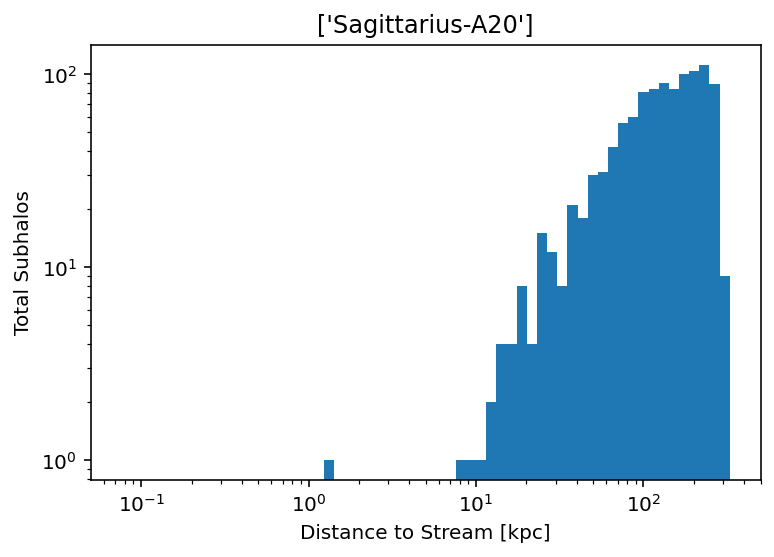

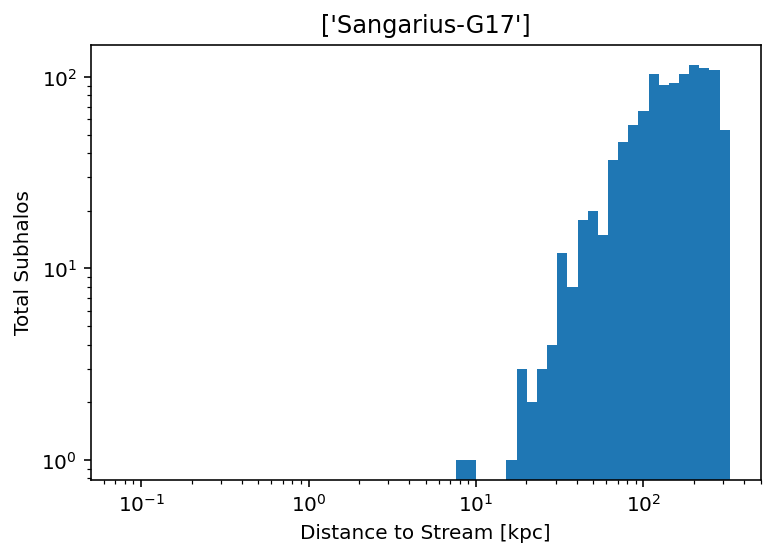

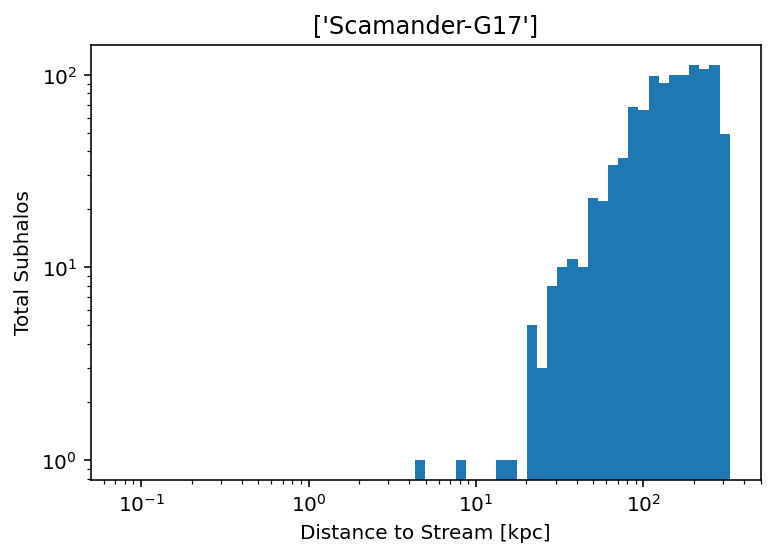

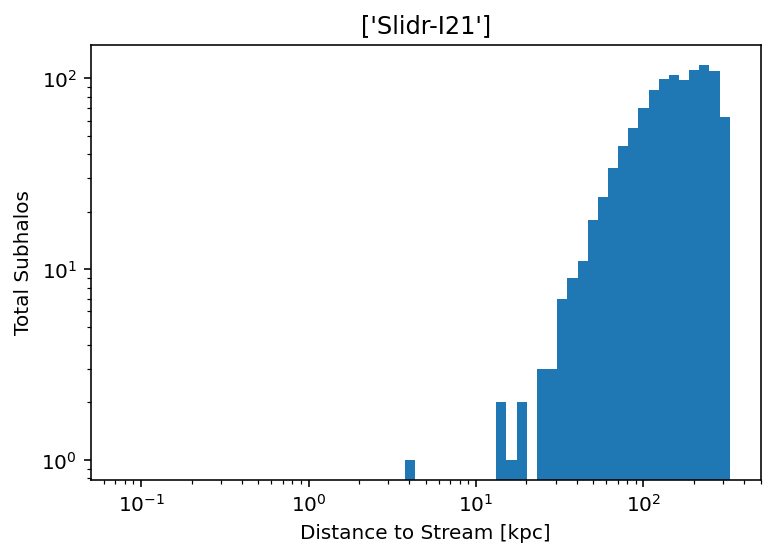

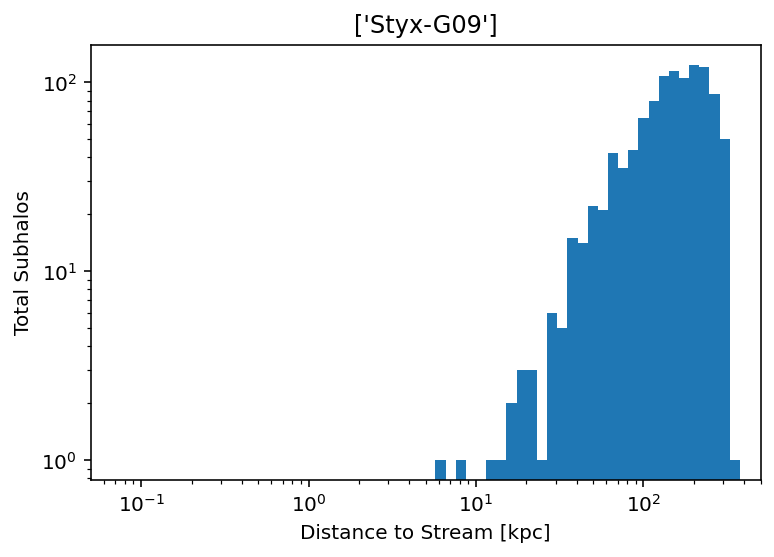

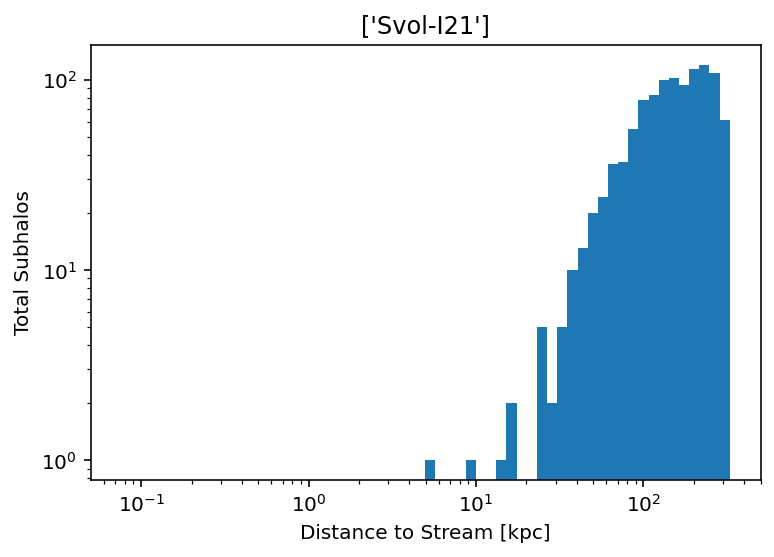

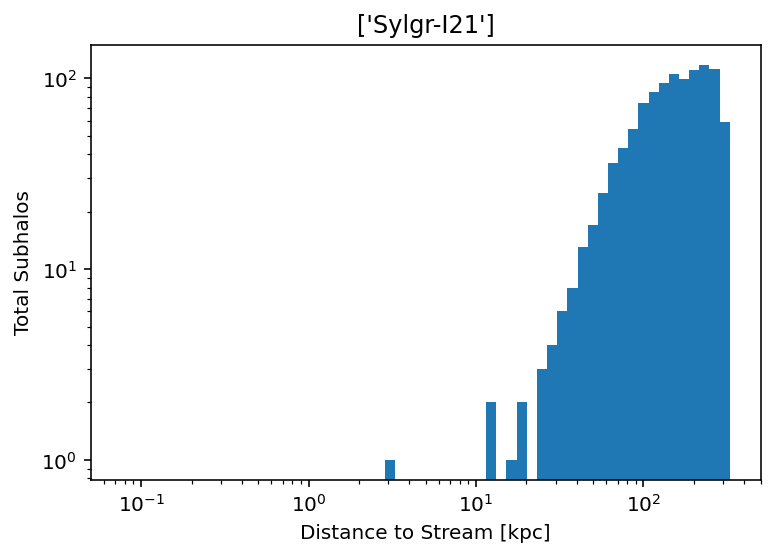

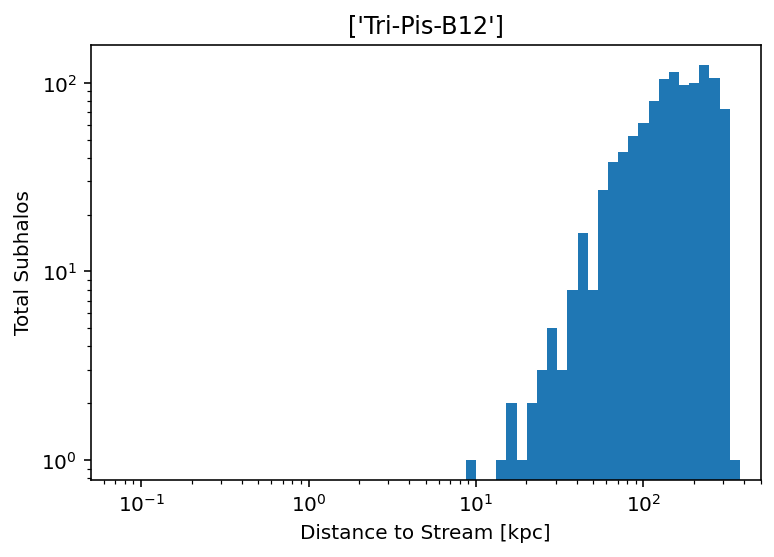

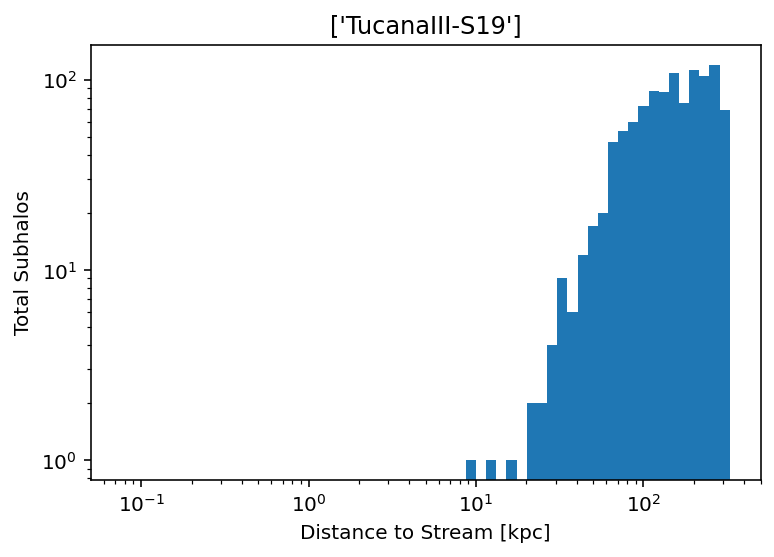

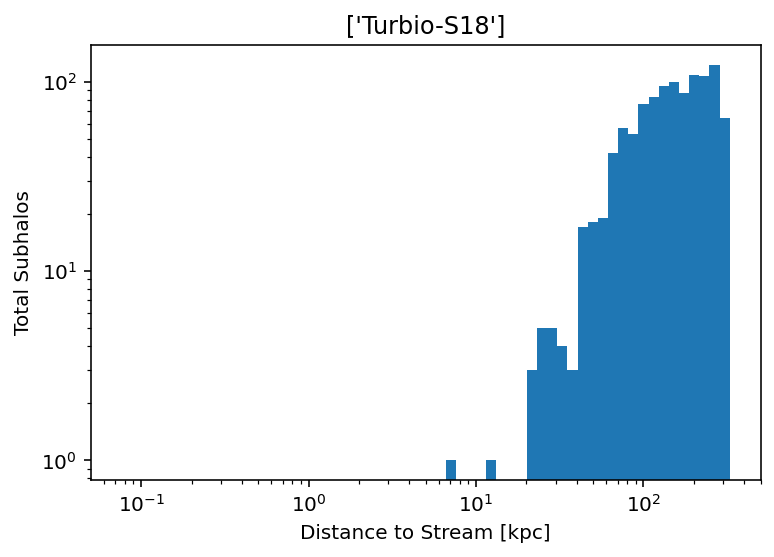

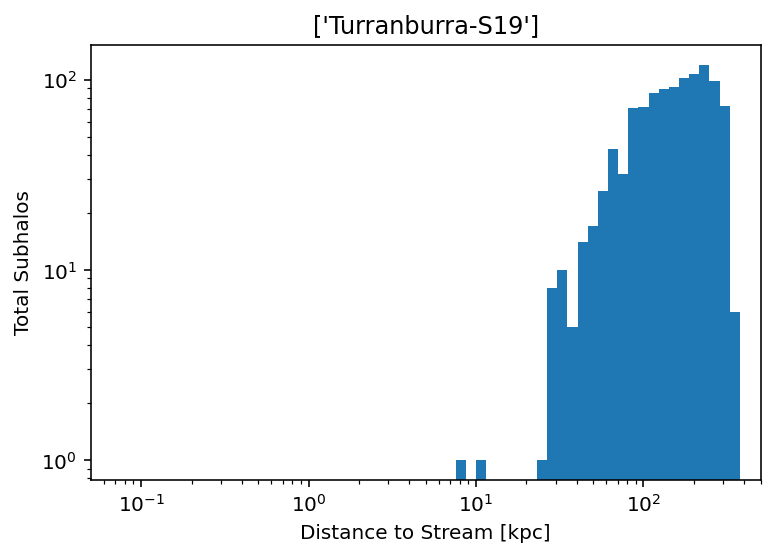

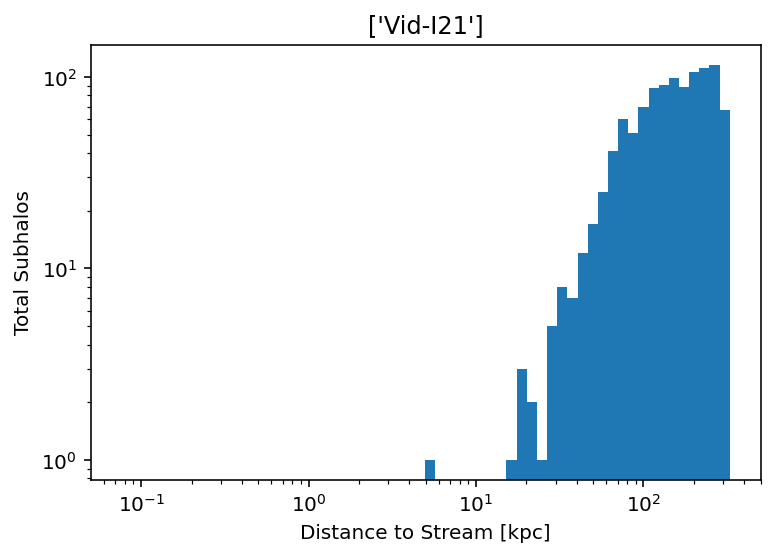

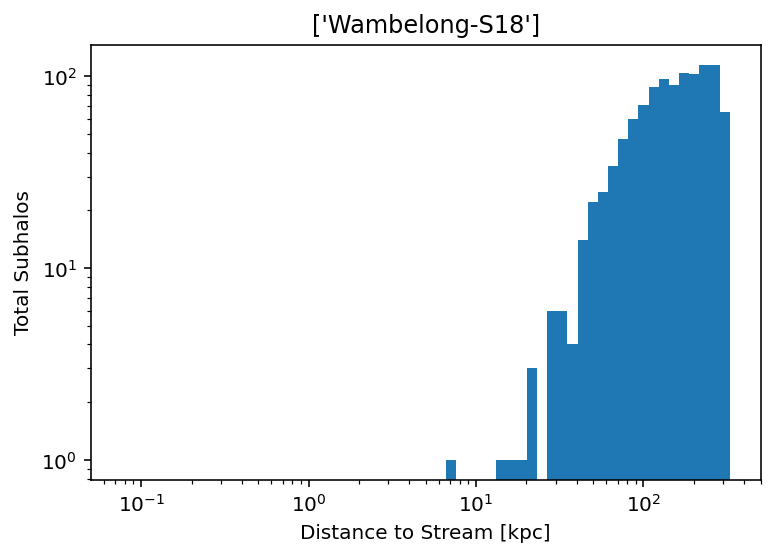

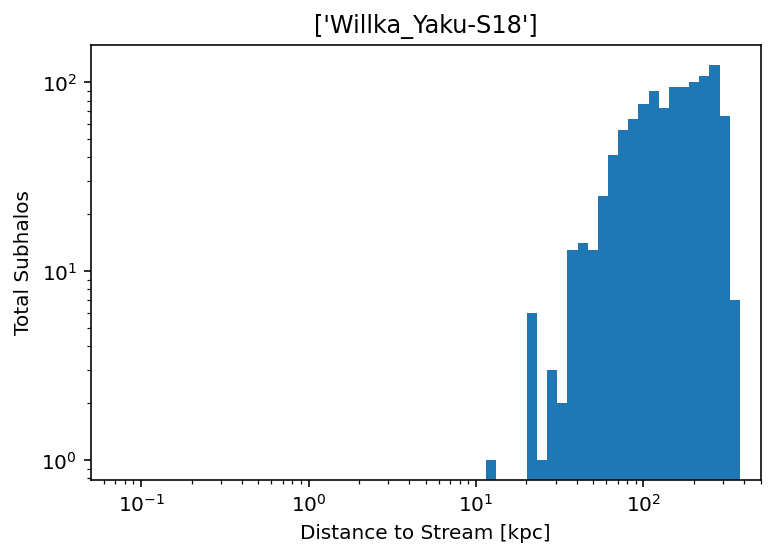

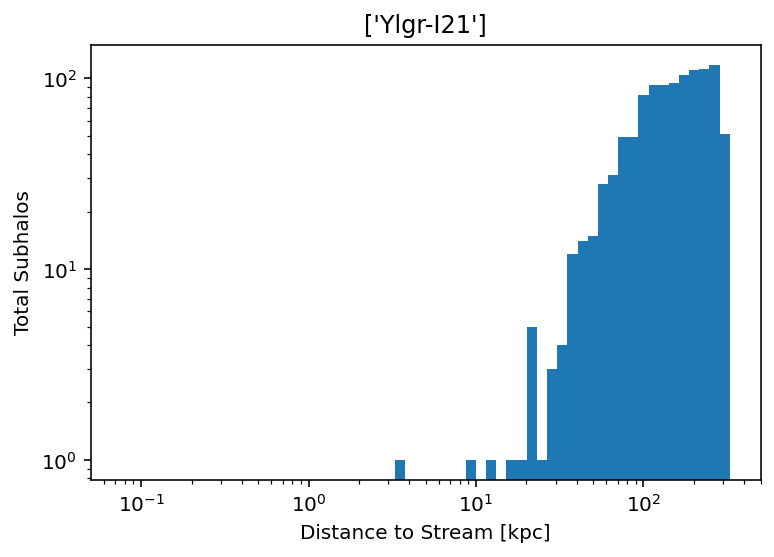

In [25]:
i=0
for row in list(rows.keys())[:]:
    plt.figure()
    fig=plt.hist(rows[row], bins=np.logspace(-1,5,100), log=True); 
    plt.gca().set_xscale('log')
    plt.title(data_complete_updated.to_numpy()[i][0:1]) 
    plt.xlim(0, 500)
    plt.xlabel('Distance to Stream [kpc]')
    plt.ylabel('Total Subhalos')
    plt.savefig('Histograms/Subhalos_Histograms_no_rs/Subhalo'+str(i)+'.png', transparent=False, dpi=200)
    i+=1

In [ ]:
i=0
for row in list(rows.keys())[:]:
    plt.figure()
    fig=plt.hist(rows[row], bins=np.linspace(-1,300,50)); #shows how many times rs the subhalos lie in
    plt.title(data_complete_updated.to_numpy()[i][0:1]) #how can I get rid of these brackets
    plt.xlabel('Distance to Stream')
    plt.ylabel('Total Subhalos')
    #plt.savefig('Histograms/Subhalos_Histograms_noLog/Subhalo'+str(i)+'no_rs_no_log.png', transparent=False)
    i+=1

In [ ]:
i=0
for row in list(rows.keys())[:]:
    plt.figure()
    fig=plt.hist(rows[row], bins=np.linspace(-1,50,50)); #shows how many times rs the subhalos lie in
    plt.title(data_complete_updated.to_numpy()[i][0:1]) #how can I get rid of these brackets
    plt.xlabel('Distance to Stream')
    plt.ylabel('Total Subhalos')
   # plt.savefig('Subhalos_Histograms_noLog/Subhalo'+str(i)+'no_rs_no_log.png', transparent=False)
    i+=1

In [ ]:
#CHECKING FOR DISTANCE CONSTRAINT
#STILL NEED TO FIX THIS 
stream=0
i=0
for row in list(rows.keys())[:]:
    if (rows[row][i]) <= (50*trot['rs'][i]): #dist of stream to subhalo should be < or = 5 times rs
        print(data_complete_updated.to_numpy()[stream][:1], 'Subhalo_'+str(i))
    stream+=1
    i+=1

In [ ]:
i

In [ ]:
#Subhalo 82 to Saggitarius-A20

In [ ]:
rows['row0']

In [ ]:
ind_lmc_new = np.argmax(trot['mvir'])
ind_lmc_new

In [ ]:
#CHECKING FOR DISTANCE CONSTRAINT
#STILL NEED TO FIX THIS 
stream=0
i=0
lst = np.arange(0,len(rows['row0']),1,dtype=int)
for row in list(rows.keys())[:]:
    #if np.any((rows[row][i])) <= (5*trot['rs'][i]): #dist of stream to subhalo should be < or = 5 times rs
    ind_close = rows[row] <= 10#5*trot['rs']
    if np.sum(ind_close)>1:
        print(data_complete_updated.to_numpy()[stream][:1], 'Subhalo_'+','.join(str(x) for x in lst[ind_close]))
    stream+=1
    #i+=1